# Custom Mean in BoTorch (1D case)


## Introduction

This is a simple example for a 1D optimization using a custom mean function and BoTorch / GPyTorch.

The first question is whether different mean functions can be more efficient at optimization:
- constant mean (default)
- quadratic mean (since bond functions are approximately $(x-r)^2$
- [Morse potential](https://en.wikipedia.org/wiki/Morse_potential) (more accurate)

In this case, for quadratic and Morse potentials, we will indicate a realistic guess as to the minima position.

Bayesian optimization usually involves a few initial points. We will pick 2 to be sample efficient and roughly bracket the minima.

The next step is using a 2D optimization with two different custom means (e.g., one for bond lengths and one for angles).

Parts of this notebook derive from [BoTorch tutorials](https://botorch.org/tutorials/)

## Imports

First we have to import a bunch of things.

In [1]:
# BoTorch components
from botorch.models.model import Model
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition.analytic import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound

from botorch.utils import standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

We'll use a simple model for water again:

In [2]:
def morse(r):
    # this is a Morse potential fit to the water O-H stretch at the MP2 level
    y = 265.79*(1.0-torch.exp(-2.253*(r-0.9624)))**2
    return y

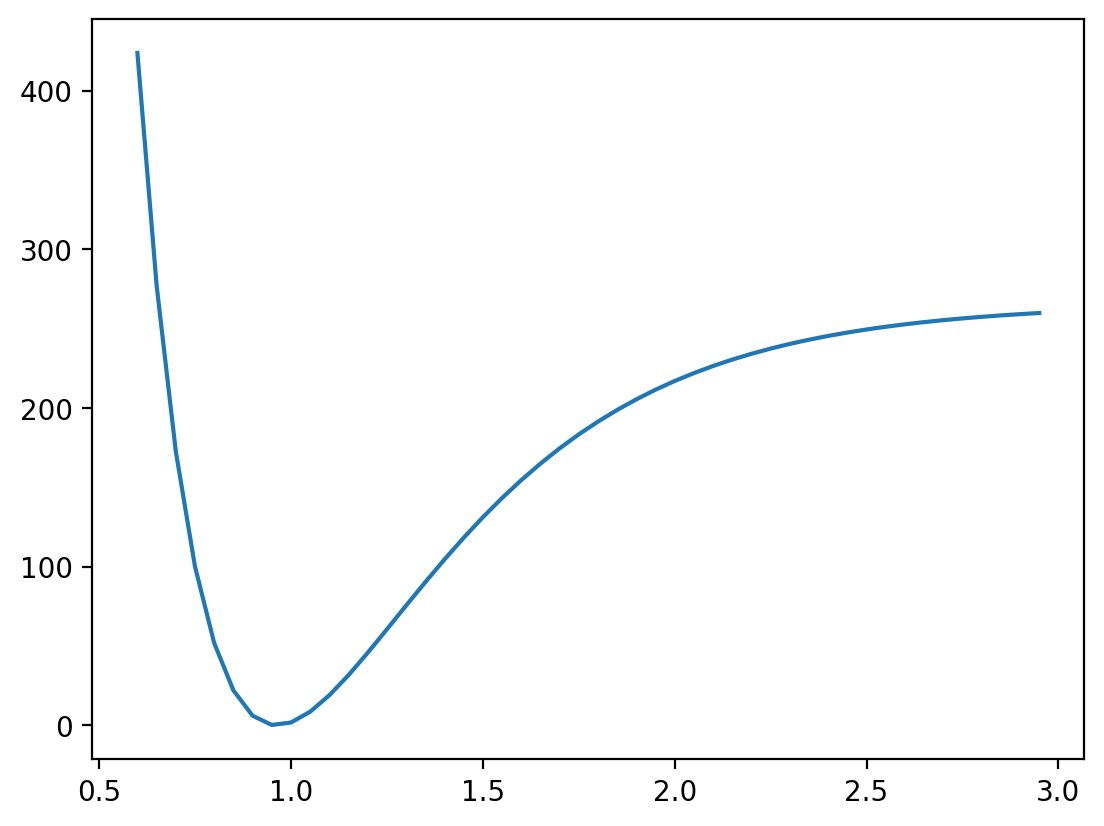

In [3]:
# let's plot this

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

x_morse = torch.arange(0.6, 3.0, 0.05)
y_morse = morse(x_morse)

plt.plot(x_morse.cpu().numpy(), y_morse.cpu().numpy())

This is artificial, as a Morse potential, but it's a good representation for many bond length energy functions.

Note that at large separation (e.g., r = 1.5 Angstrom), the gradient might not be large. Similarly, close to the minimum, the gradients will be small.

Ideally, we should benchmark a BoTorch optimization like this against a gradient descent or BFGS optimization in terms of the number of steps.

## Use a Pre-constructed BoTorch Model

We can create some training data and a custom GPyTorch model before running BoTorch

In [4]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean, Mean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, RQKernel, PolynomialKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior

# A configurable mean function using the Morse potential
class MorseMean(Mean):
    def __init__(self, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(name="depth", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        self.register_parameter(name="center", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        self.register_parameter(name="alpha", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        if bias:
            self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        else:
            self.bias = None

    def forward(self, x):
        position = x - self.center
        res = torch.exp(-1*self.alpha * position)
        res = self.depth * (1 - res)**2
        if self.bias is not None:
            res = res + self.bias
        return res.squeeze(-1)

# A configurable mean function using a quadratic
class QuadraticMean(Mean):
    def __init__(self, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        self.register_parameter(name="center", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        if bias:
            self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        else:
            self.bias = None

    def forward(self, x):
        #print(x.shape, self.center.shape)
        offset_sq = (x - self.center)**2
        res = torch.mul(self.weights, offset_sq)
        if self.bias is not None:
            res = res + self.bias
        return res.squeeze(-1)

    
# this should be cleaned up but works for now
# TODO: enable a parameter for the center parameter (or others)
# TODO: add sub-classes for the constant mean, quadratic, and Morse potential
class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API - only one output (energies)
    
    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        
        #self.mean_module = ConstantMean()
        #self.mean_module = QuadraticMean()
        self.mean_module = MorseMean()
        # for Quadratic and MorseMean classes, add an estimate for the minima
        self.mean_module.initialize(center = torch.tensor([0.962]))
        
        # scale kernel allows rescaling to fit the output Y values
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype - cpu or gpu
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

Okay, now we have a custom model, and we want to fit on our initial data (with no noise):

In [15]:
from botorch.fit import fit_gpytorch_model
import matplotlib.pyplot as plt

# These might be initial data points
#  .. or we could intentionally pick some good points to bias the BayesOpt
#  .. here, we're picking both sides of the minima (0.7, 2.0) and close to the bottom (1.0)
initial_x = torch.tensor([0.55, 2.7, 1.4], device=device, dtype=dtype)
initial_y = morse(initial_x)

model = SimpleCustomGP(initial_x, initial_y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll);
model.eval()

SimpleCustomGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): MorseMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


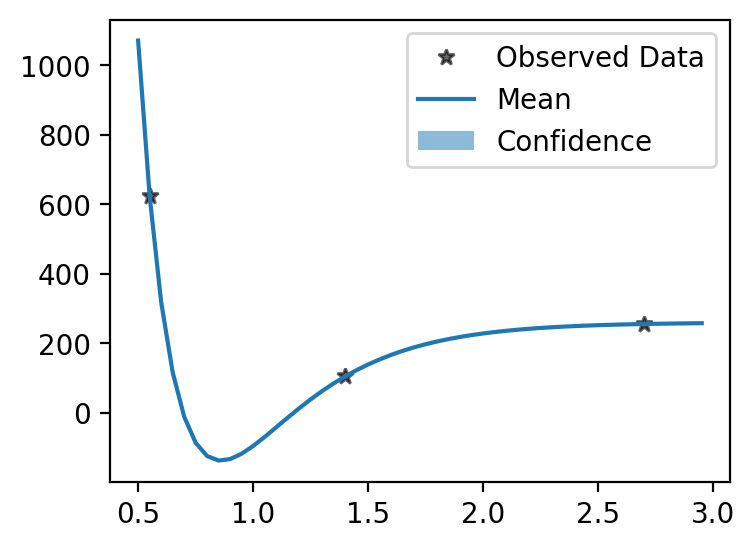

In [16]:
train_x = initial_x
train_y = initial_y
test_x = torch.arange(0.5, 3.0, 0.05)

with torch.no_grad(): 
    posterior = model.posterior(test_x) 
    # these are 2 std devs from mean 
    lower, upper = posterior.mvn.confidence_region() 

    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.6, label="observations") 
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), label="GP posterior")
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## Training Loop

This sets up a training loop. For 25 trials, it will run the optimization loop, terminating when the change in energy from one step to the next is below 0.01 and the step norm is < 0.25 (i.e., it's very close to the minimum).

Things to try:
- aquisition function (UCB, EI, PoI)
- beta parameter for UCB
- number of initial points in initial_x used above

/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status

0 ['1.769072'] 186.4524 Delta=81.9955 Norm=0.369
1 ['0.962400'] 0.0000 Delta=-186.4524 Norm=0.807
2 ['0.962399'] 0.0000 Delta=0.0000 Norm=0.000
Done in 2
0 ['2.438919'] 247.0411 Delta=142.5841 Norm=1.039
1 ['0.962402'] 0.0000 Delta=-247.0411 Norm=1.477
2 ['2.881244'] 258.7890 Delta=258.7890 Norm=1.919
3 ['0.956315'] 0.0506 Delta=-258.7384 Norm=1.925
4 ['1.054624'] 9.3557 Delta=9.3051 Norm=0.098
5 ['0.995131'] 1.3432 Delta=-8.0125 Norm=0.059
6 ['0.880408'] 10.9413 Delta=9.5981 Norm=0.115
7 ['0.944265'] 0.4623 Delta=-10.4790 Norm=0.064
8 ['0.945428'] 0.4038 Delta=-0.0584 Norm=0.001
9 ['0.962270'] 0.0000 Delta=-0.4038 Norm=0.017
10 ['0.962400'] 0.0000 Delta=-0.0000 Norm=0.000
Done in 10
0 ['2.024150'] 219.4069 Delta=114.9500 Norm=0.624
1 ['1.399996'] 104.4559 Delta=-114.9510 Norm=0.624


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status

2 ['1.583579'] 150.8189 Delta=46.3630 Norm=0.184


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status

3 ['3.000000'] 260.4241 Delta=109.6052 Norm=1.416
4 ['0.692531'] 186.1068 Delta=-74.3174 Norm=2.307
5 ['1.326224'] 83.1835 Delta=-102.9232 Norm=0.634


/var/folders/0m/5nzvp3cx1656wq7tyw8v8c6w0000gn/T/ipykernel_36707/3362173690.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(1, 2, figsize=(4, 3))


6 ['1.905300'] 206.0569 Delta=122.8734 Norm=0.579
7 ['0.962399'] 0.0000 Delta=-206.0569 Norm=0.943
8 ['0.998217'] 1.5975 Delta=1.5975 Norm=0.036
9 ['0.500000'] 894.2705 Delta=892.6730 Norm=0.498
10 ['0.883446'] 10.0742 Delta=-884.1963 Norm=0.383
11 ['0.962400'] 0.0000 Delta=-10.0742 Norm=0.079
12 ['0.973272'] 0.1556 Delta=0.1556 Norm=0.011
13 ['2.406080'] 245.6297 Delta=245.4741 Norm=1.433
14 ['0.962399'] 0.0000 Delta=-245.6297 Norm=1.444
15 ['0.962403'] 0.0000 Delta=0.0000 Norm=0.000
Done in 15
0 ['2.482268'] 248.7567 Delta=144.2998 Norm=1.082
1 ['1.081046'] 14.6239 Delta=-234.1328 Norm=1.401
2 ['0.693003'] 185.2393 Delta=170.6154 Norm=0.388
3 ['0.962400'] 0.0000 Delta=-185.2393 Norm=0.269
4 ['0.962400'] 0.0000 Delta=0.0000 Norm=0.000
Done in 4
0 ['1.400002'] 104.4574 Delta=0.0005 Norm=0.000
1 ['1.333817'] 85.4205 Delta=-19.0369 Norm=0.066
2 ['3.000000'] 260.4241 Delta=175.0036 Norm=1.666
3 ['1.209582'] 48.4654 Delta=-211.9588 Norm=1.790
4 ['1.956877'] 212.2392 Delta=163.7739 Norm=0.7

/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status

1 ['1.520013'] 135.9907 Delta=-112.5757 Norm=0.957
2 ['1.162716'] 35.0629 Delta=-100.9278 Norm=0.357


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status

3 ['1.908634'] 206.4758 Delta=171.4129 Norm=0.746
4 ['0.500000'] 894.2705 Delta=687.7947 Norm=1.409
5 ['0.962400'] 0.0000 Delta=-894.2705 Norm=0.462
6 ['0.962400'] 0.0000 Delta=0.0000 Norm=0.000
Done in 6
0 ['0.890344'] 8.2577 Delta=-96.1992 Norm=0.510
1 ['0.962400'] 0.0000 Delta=-8.2577 Norm=0.072
2 ['0.962401'] 0.0000 Delta=0.0000 Norm=0.000
Done in 2
0 ['1.400007'] 104.4589 Delta=0.0020 Norm=0.000
1 ['0.895771'] 6.9726 Delta=-97.4863 Norm=0.504
2 ['1.776261'] 187.6161 Delta=180.6436 Norm=0.880
3 ['0.936616'] 0.9508 Delta=-186.6653 Norm=0.840
4 ['0.962400'] 0.0000 Delta=-0.9508 Norm=0.026
5 ['0.962401'] 0.0000 Delta=0.0000 Norm=0.000
Done in 5
0 ['1.400003'] 104.4578 Delta=0.0009 Norm=0.000
1 ['1.735296'] 180.7779 Delta=76.3200 Norm=0.335
2 ['0.962399'] 0.0000 Delta=-180.7779 Norm=0.773
3 ['1.805639'] 192.2159 Delta=192.2159 Norm=0.843
4 ['0.500000'] 894.2705 Delta=702.0546 Norm=1.306
5 ['0.962400'] 0.0000 Delta=-894.2705 Norm=0.462
6 ['0.904946'] 5.0761 Delta=5.0761 Norm=0.057


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status

7 ['1.117918'] 23.2216 Delta=18.1455 Norm=0.213


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status

8 ['3.000000'] 260.4241 Delta=237.2026 Norm=1.882
9 ['0.962401'] 0.0000 Delta=-260.4241 Norm=2.038


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/mayankgoel/miniconda3/envs/G

10 ['2.325921'] 241.7335 Delta=241.7335 Norm=1.364
11 ['0.962399'] 0.0000 Delta=-241.7335 Norm=1.364
12 ['0.962400'] 0.0000 Delta=-0.0000 Norm=0.000
Done in 12
0 ['1.400000'] 104.4570 Delta=0.0001 Norm=0.000
1 ['2.904170'] 259.1392 Delta=154.6822 Norm=1.504
2 ['1.958940'] 212.4737 Delta=-46.6655 Norm=0.945
3 ['1.119778'] 23.6868 Delta=-188.7869 Norm=0.839
4 ['0.962400'] 0.0000 Delta=-23.6868 Norm=0.157
5 ['0.500000'] 894.2705 Delta=894.2705 Norm=0.462
6 ['1.103789'] 19.7796 Delta=-874.4909 Norm=0.604
7 ['1.022295'] 4.2354 Delta=-15.5442 Norm=0.081
8 ['0.941931'] 0.5921 Delta=-3.6433 Norm=0.080
9 ['0.962400'] 0.0000 Delta=-0.5921 Norm=0.020
10 ['0.948943'] 0.2519 Delta=0.2519 Norm=0.013
11 ['0.962400'] 0.0000 Delta=-0.2519 Norm=0.013
12 ['2.321572'] 241.5023 Delta=241.5023 Norm=1.359
13 ['0.962400'] 0.0000 Delta=-241.5023 Norm=1.359
14 ['1.683644'] 171.4184 Delta=171.4184 Norm=0.721
15 ['0.962400'] 0.0000 Delta=-171.4184 Norm=0.721
16 ['0.962400'] 0.0000 Delta=0.0000 Norm=0.000
Done in 

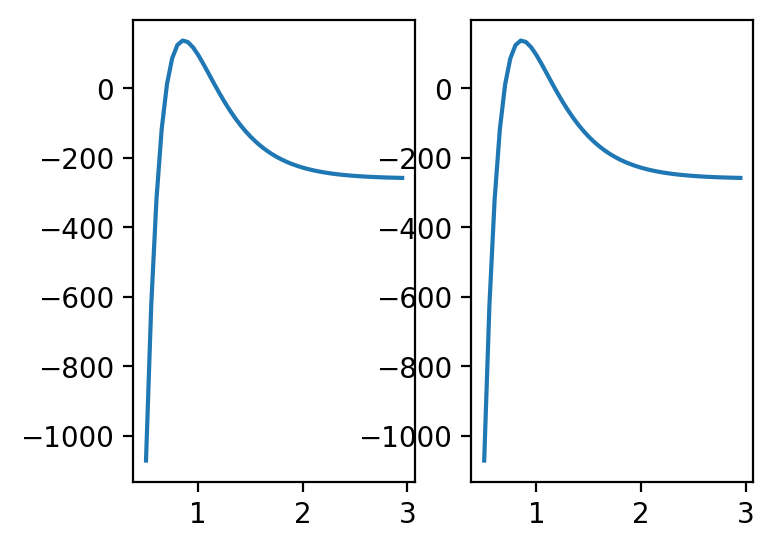

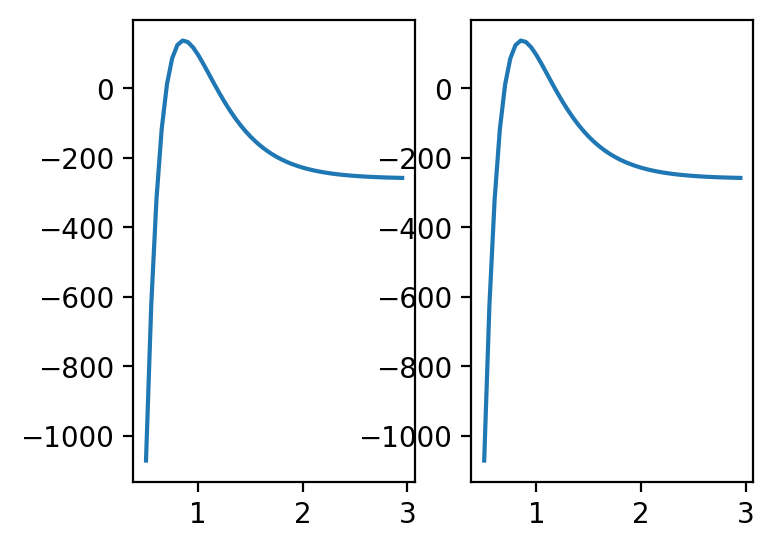

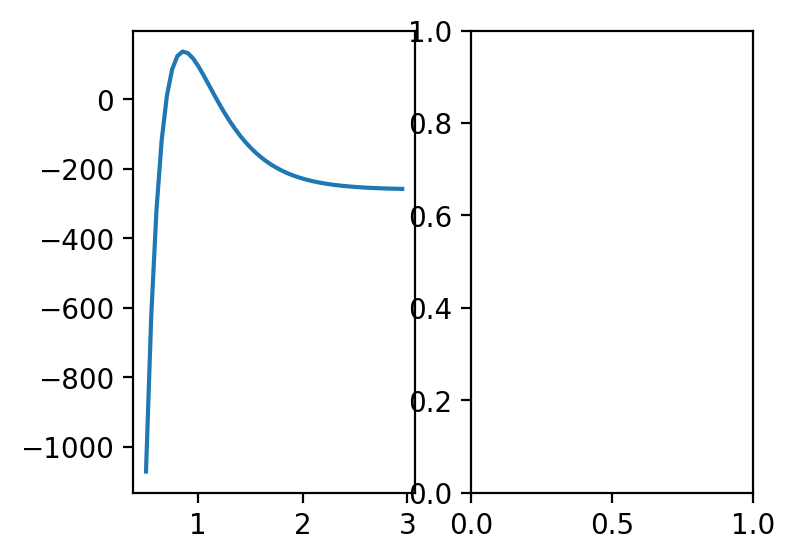

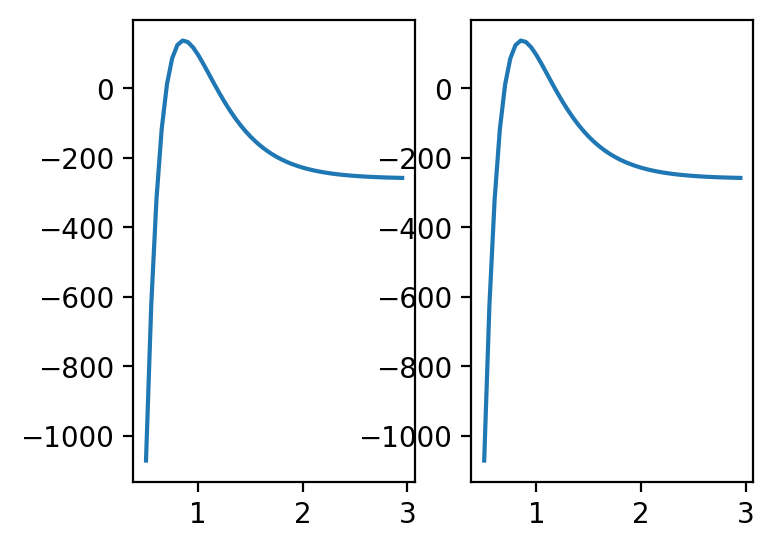

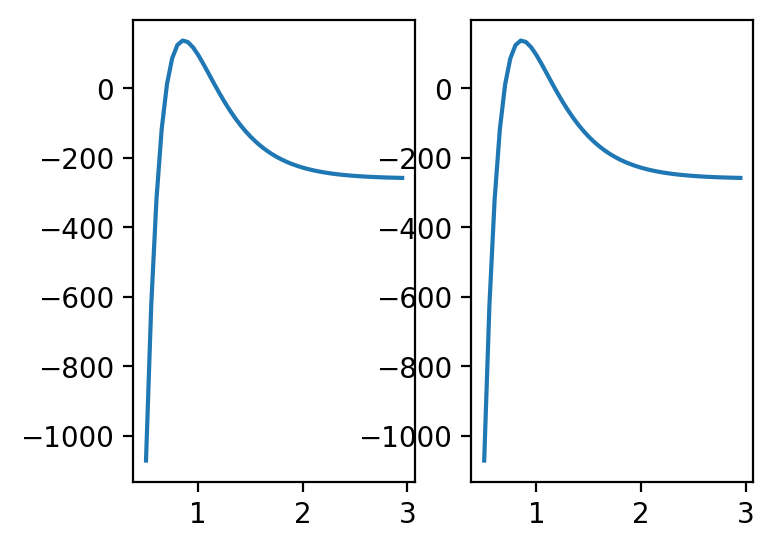

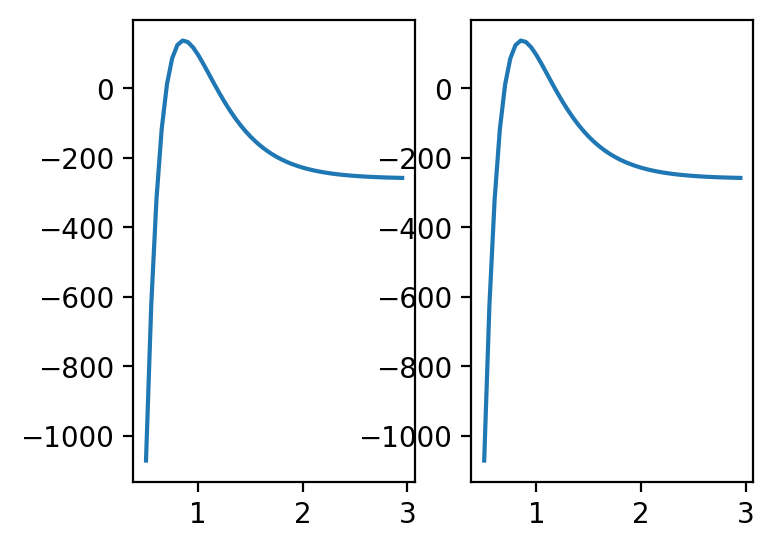

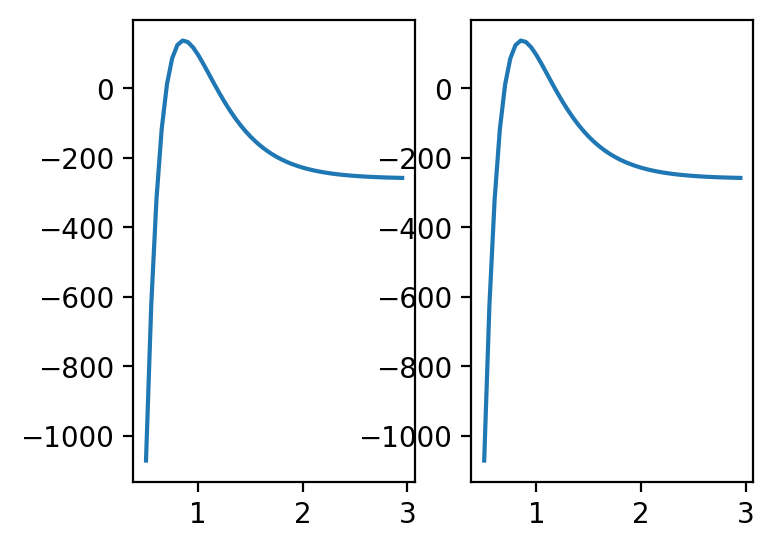

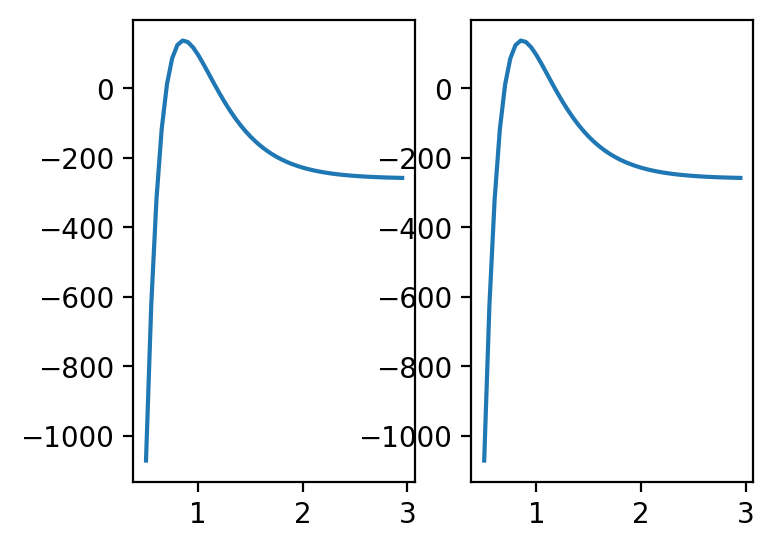

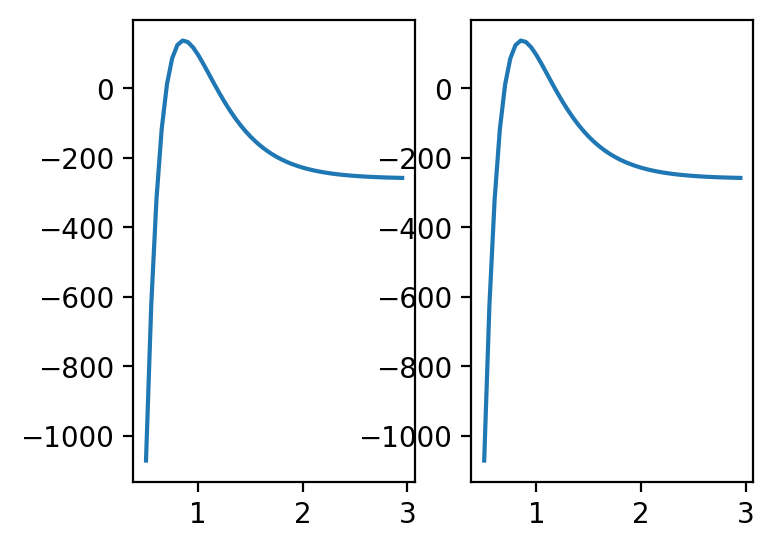

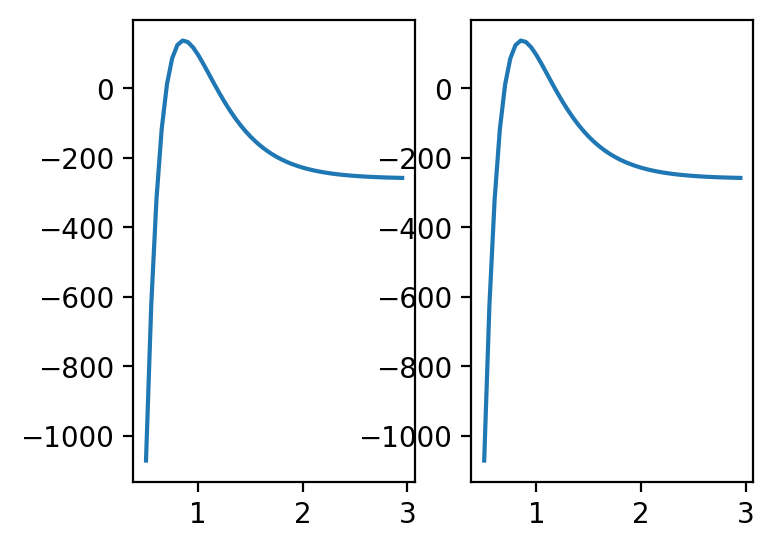

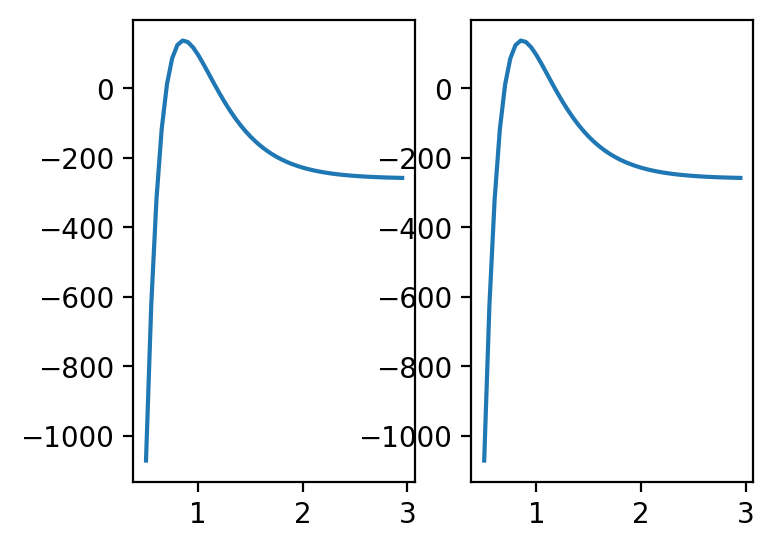

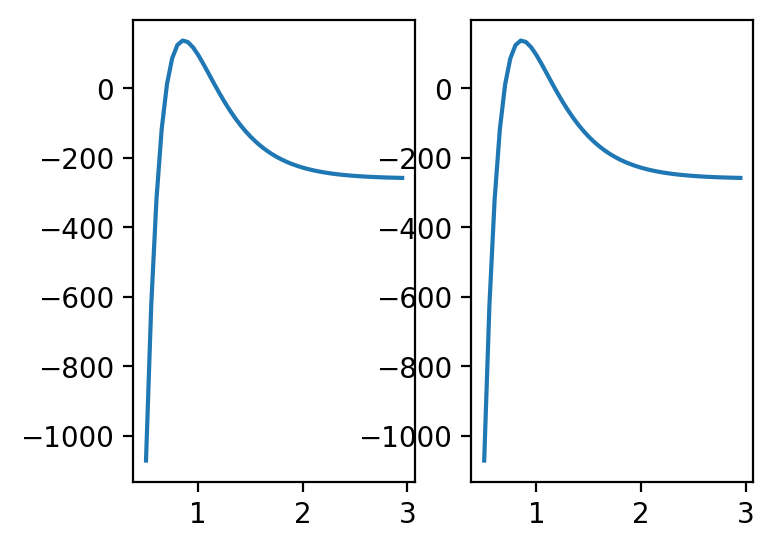

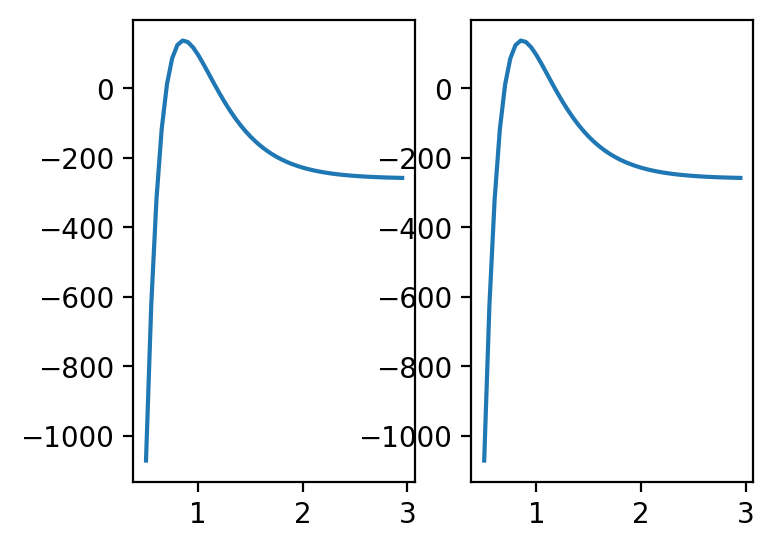

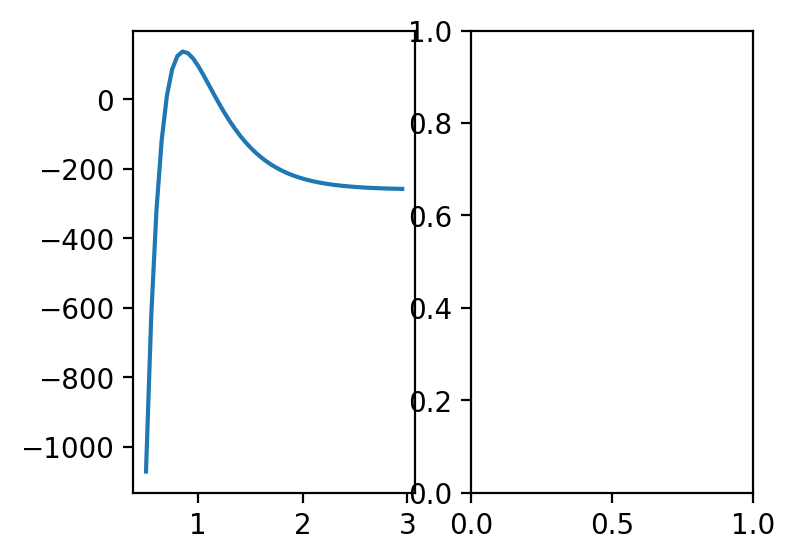

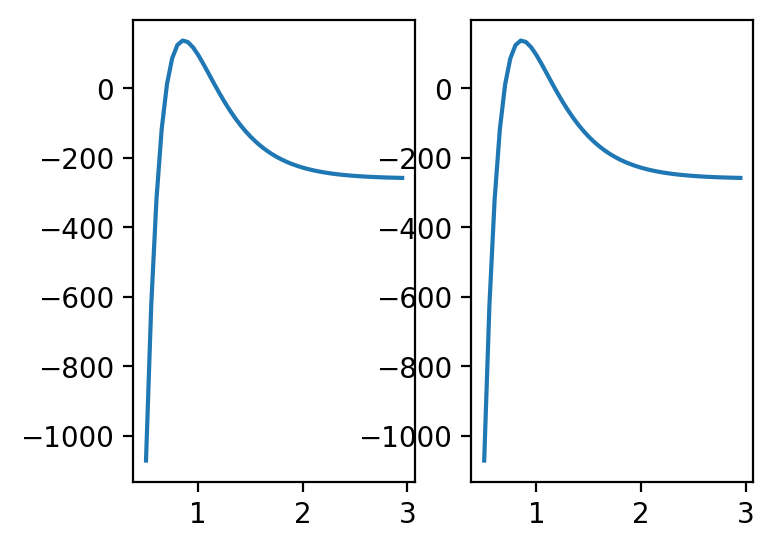

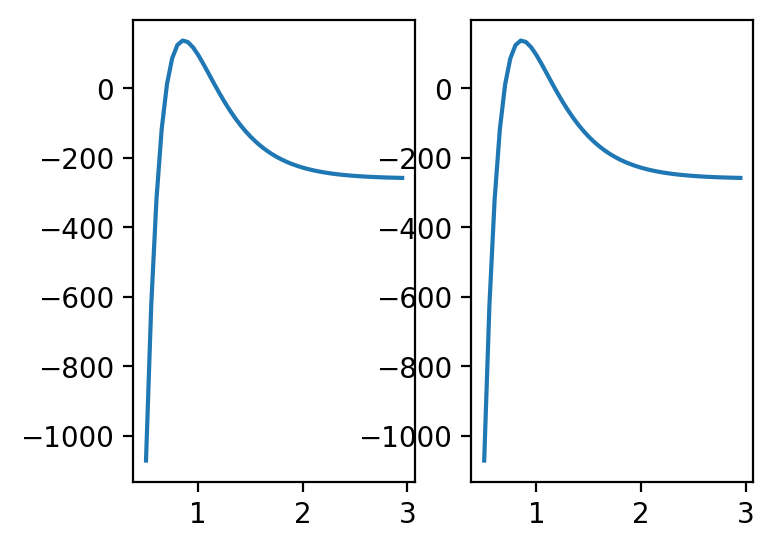

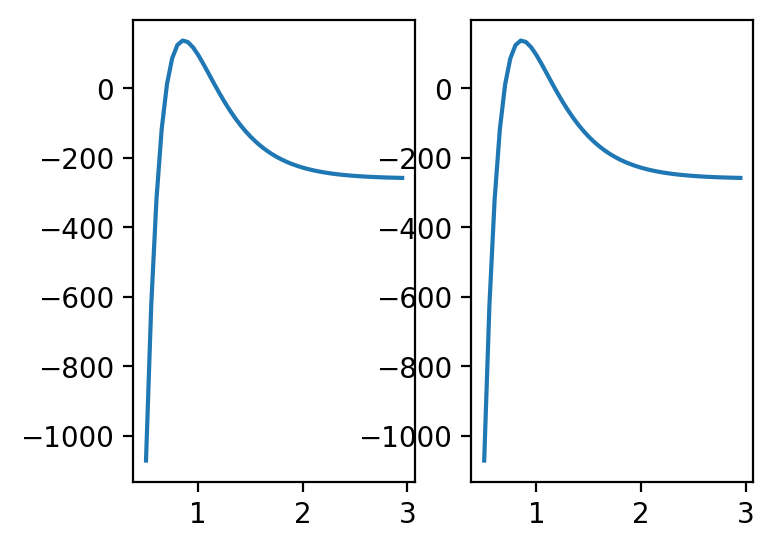

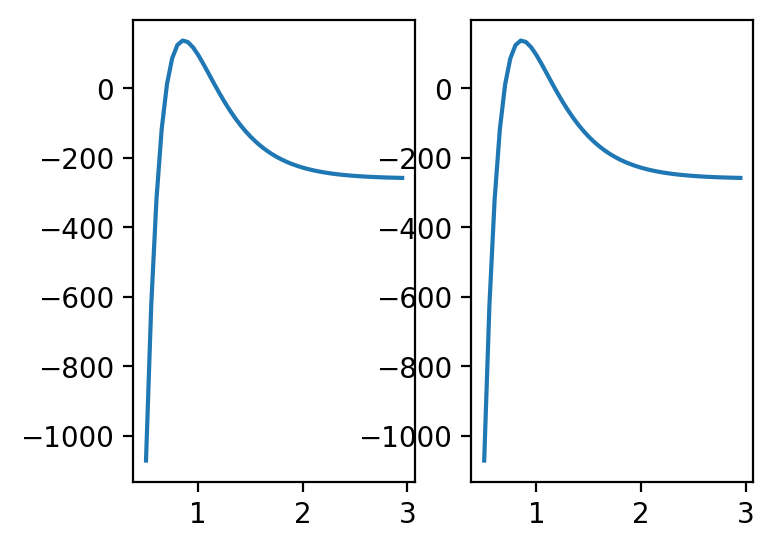

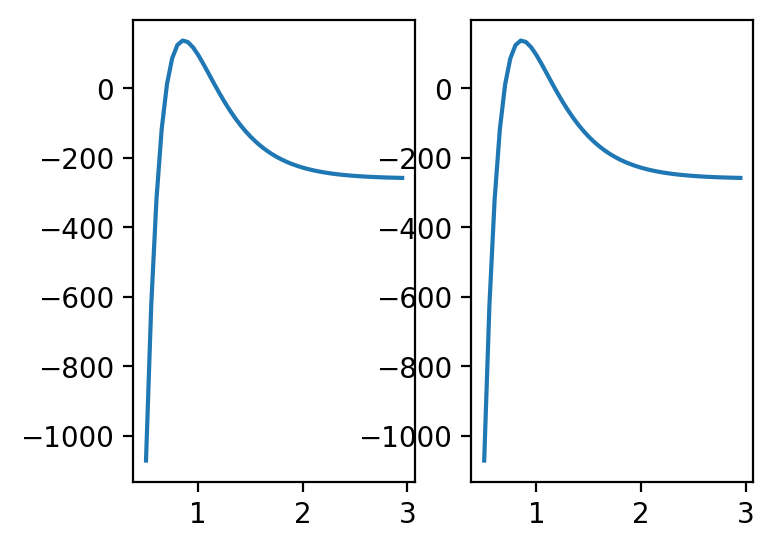

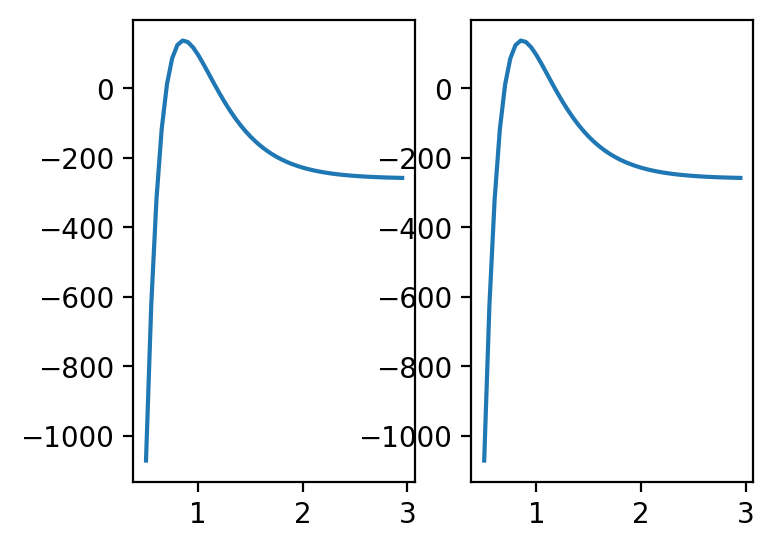

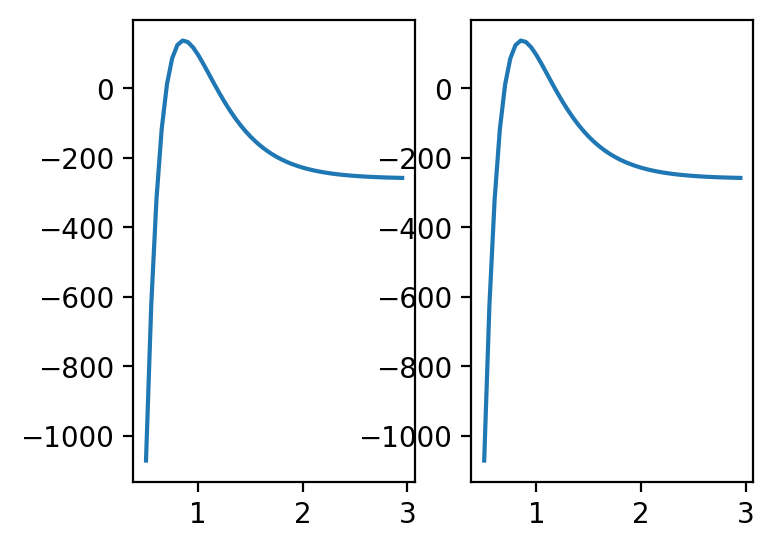

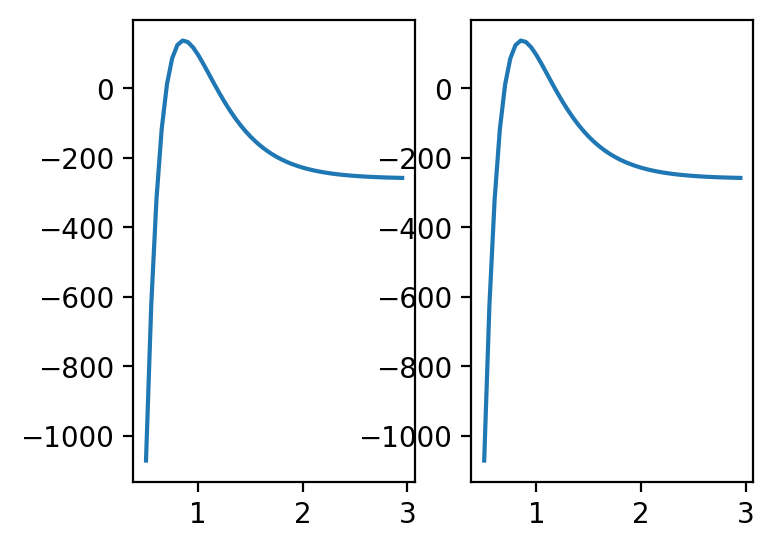

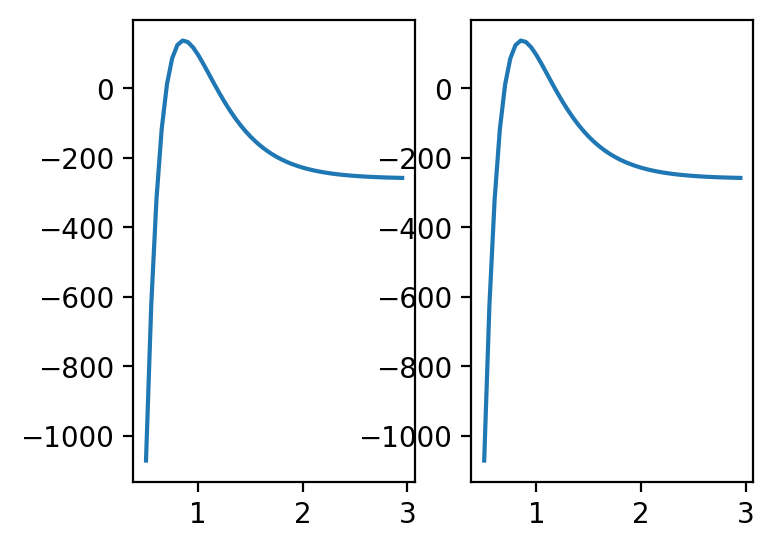

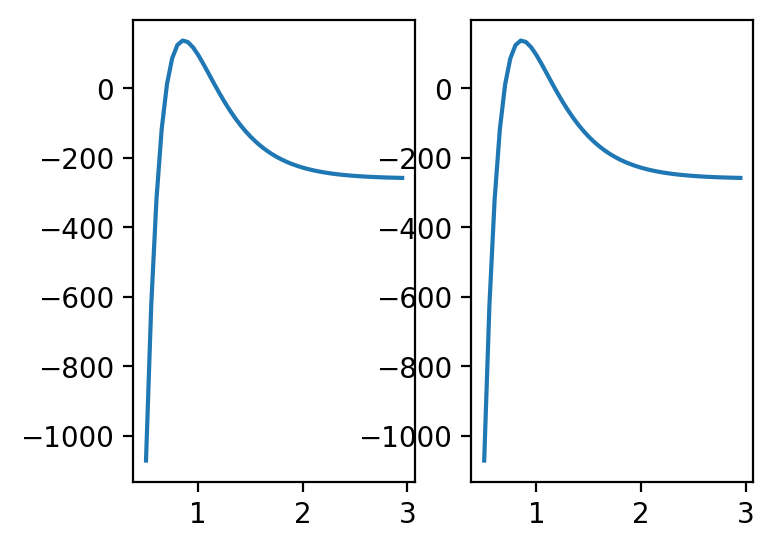

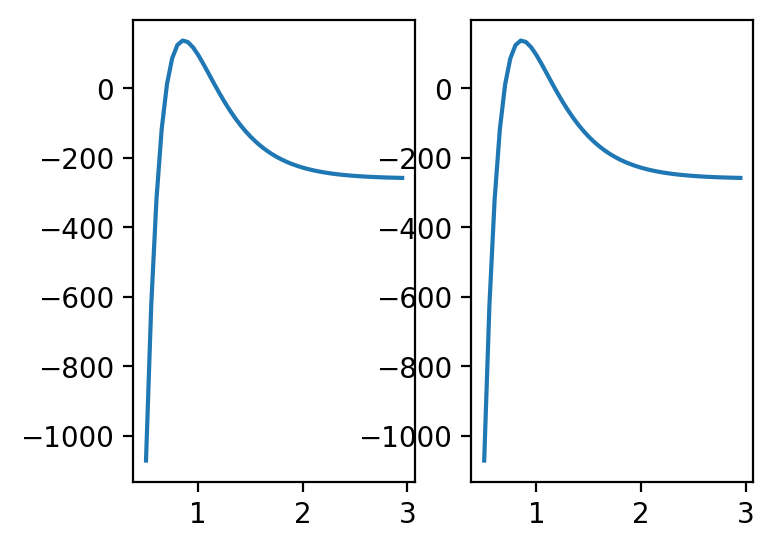

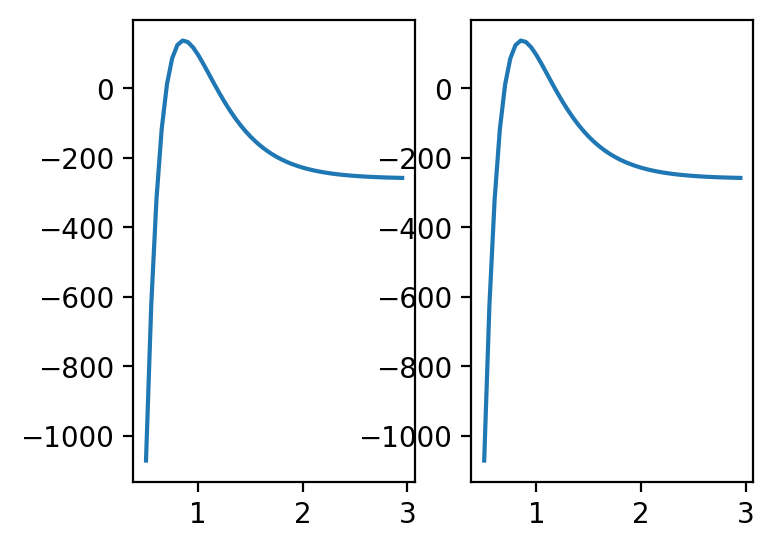

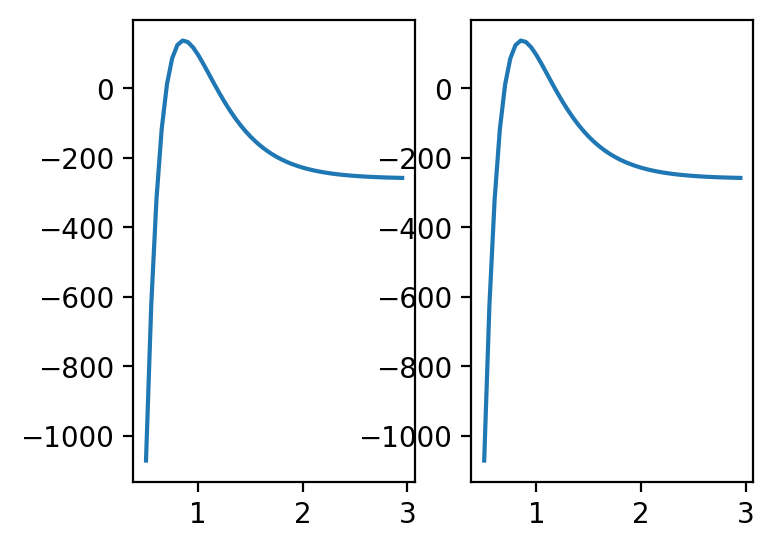

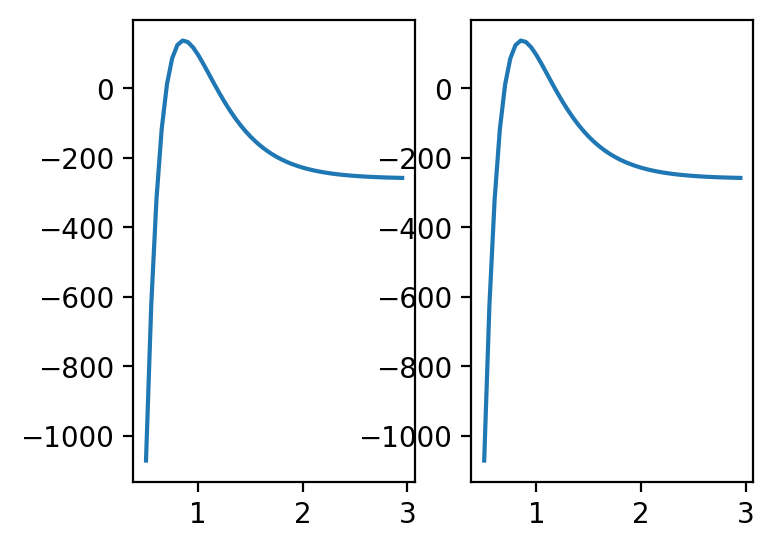

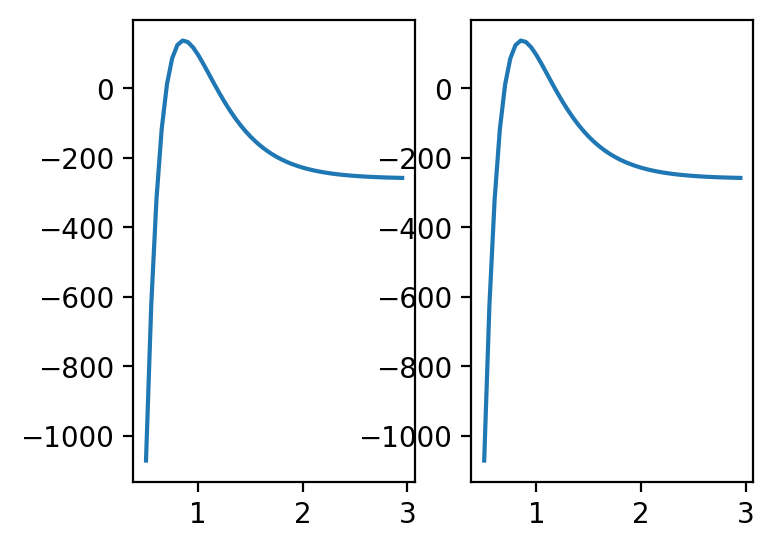

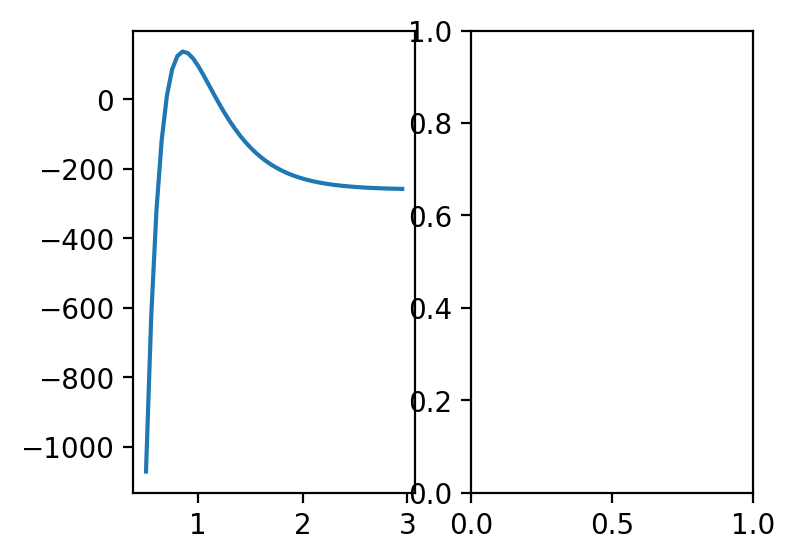

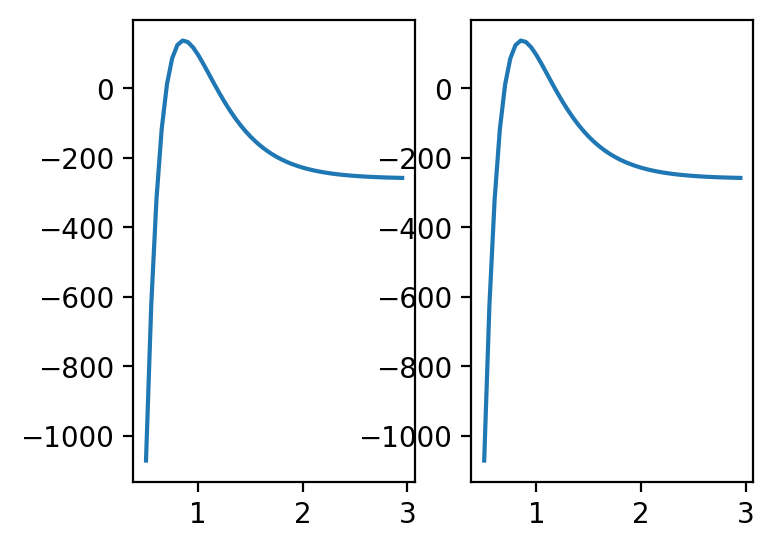

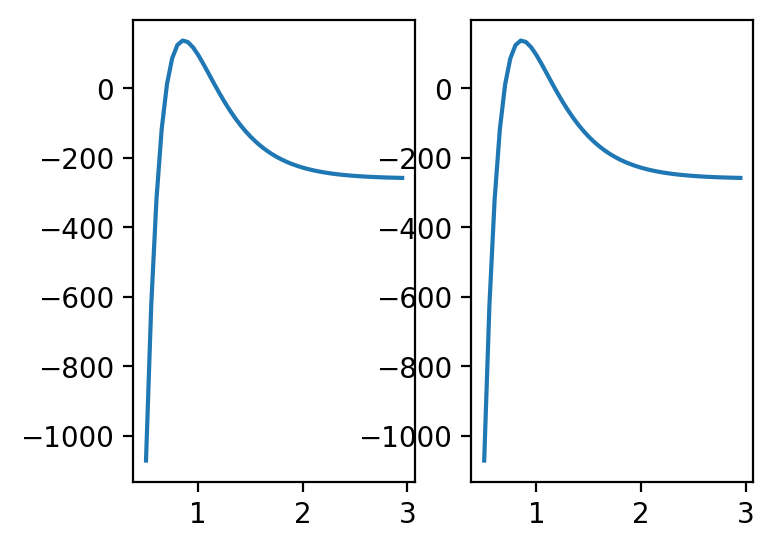

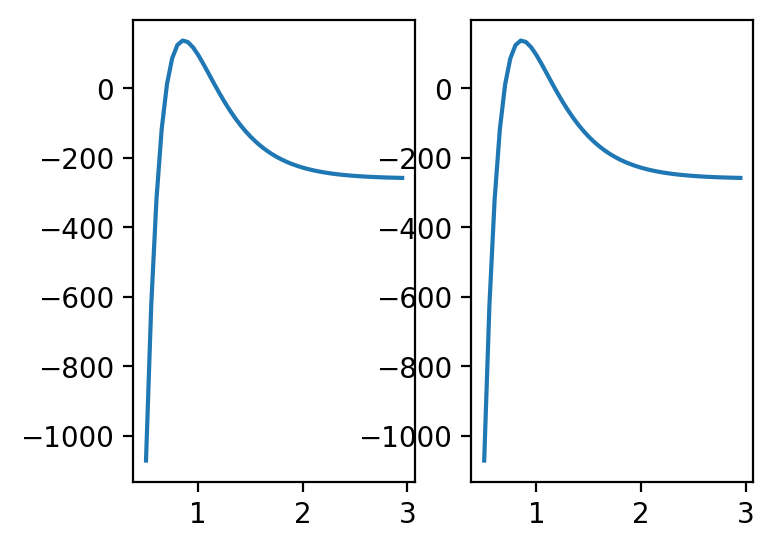

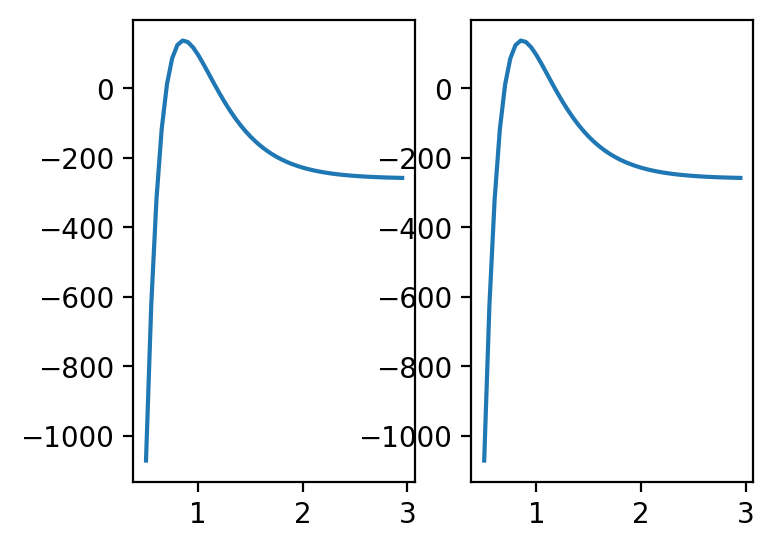

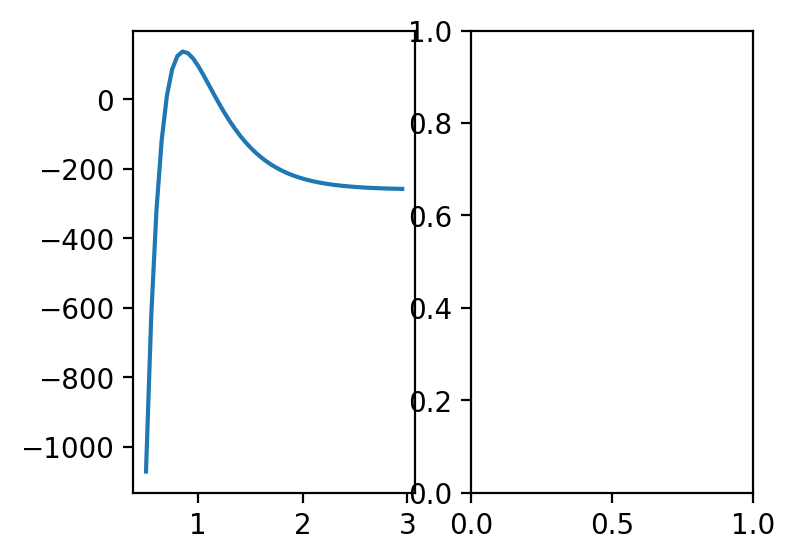

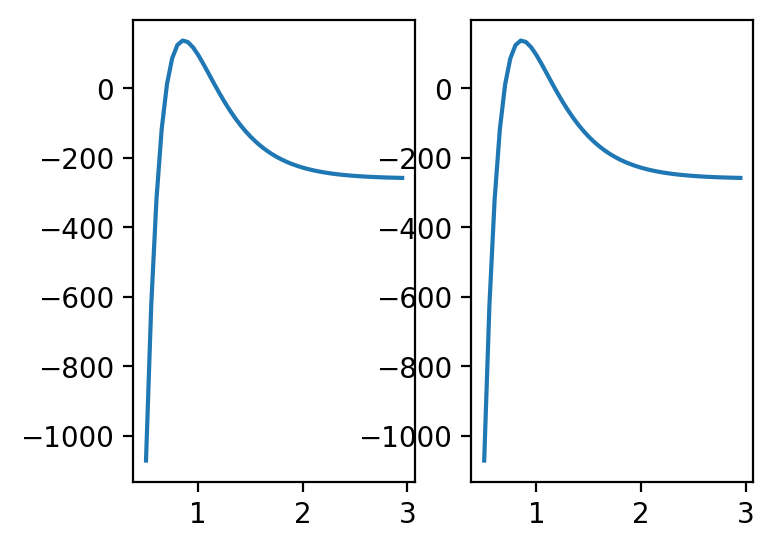

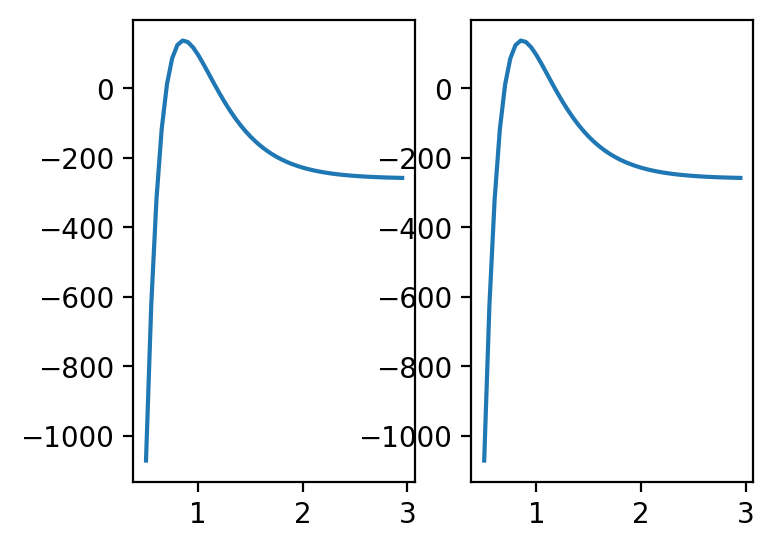

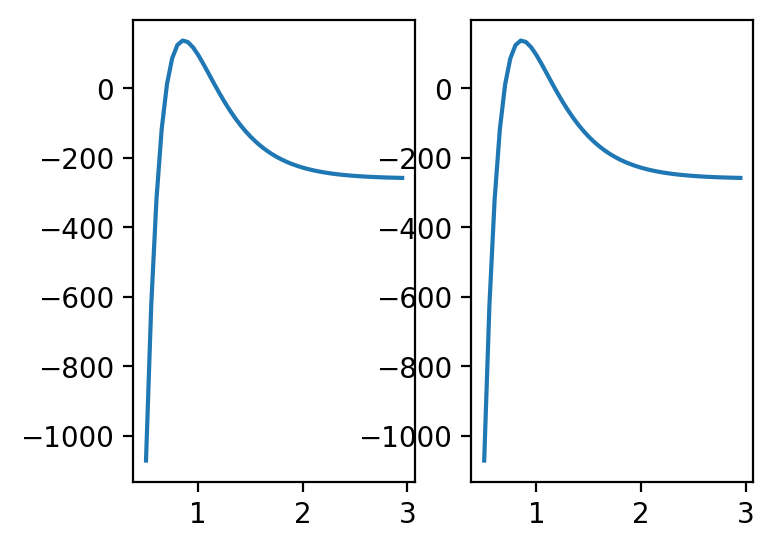

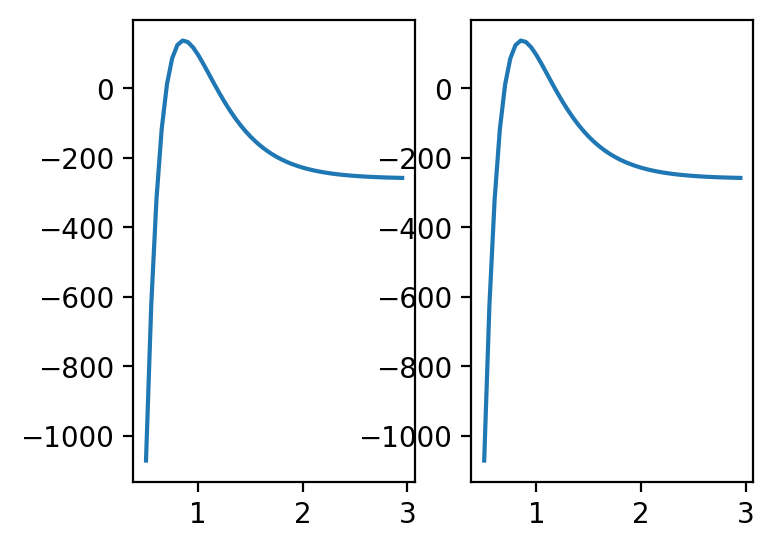

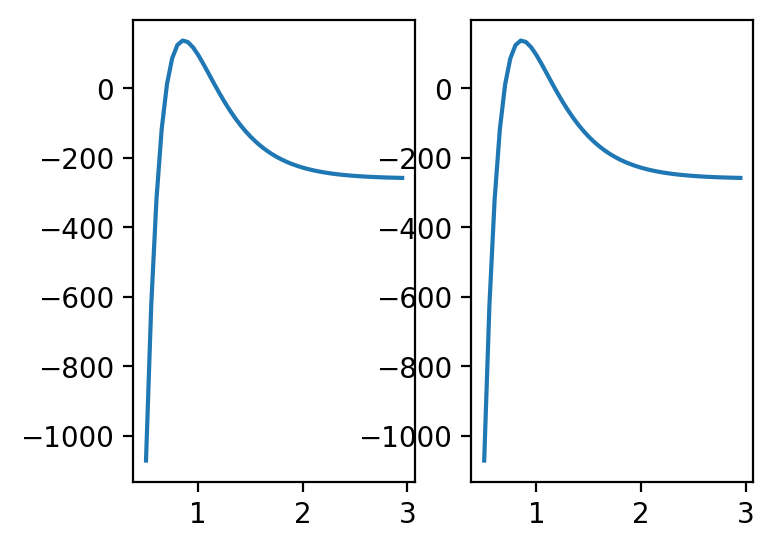

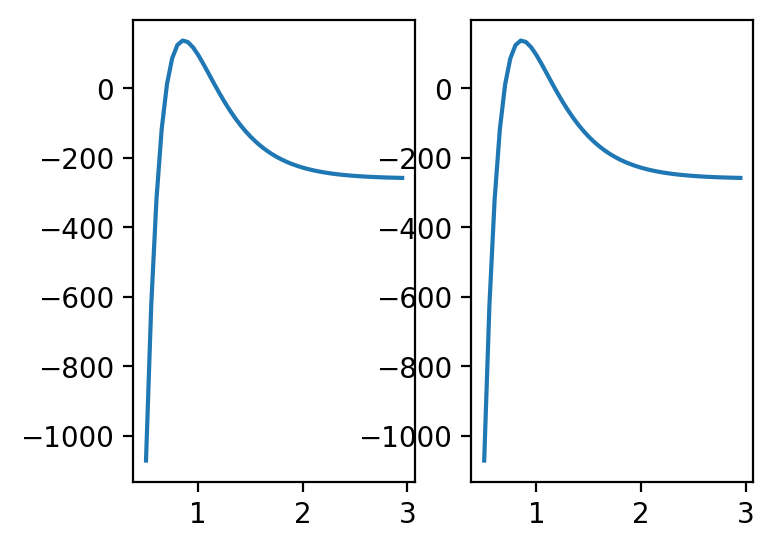

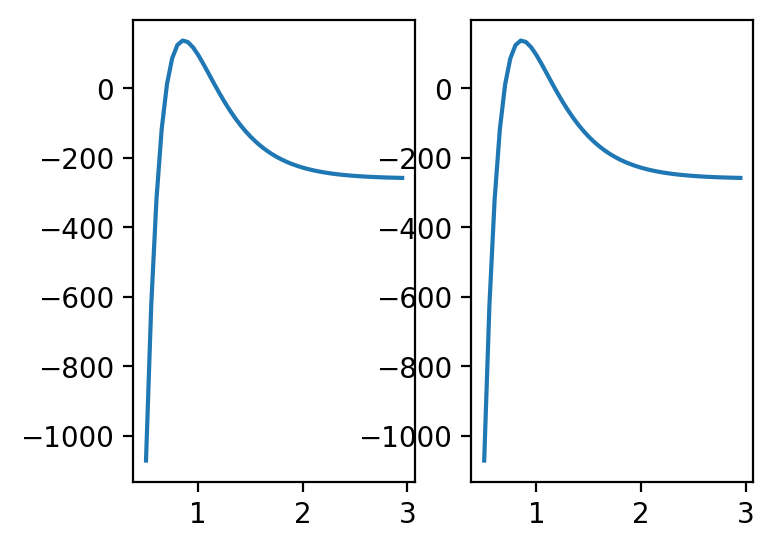

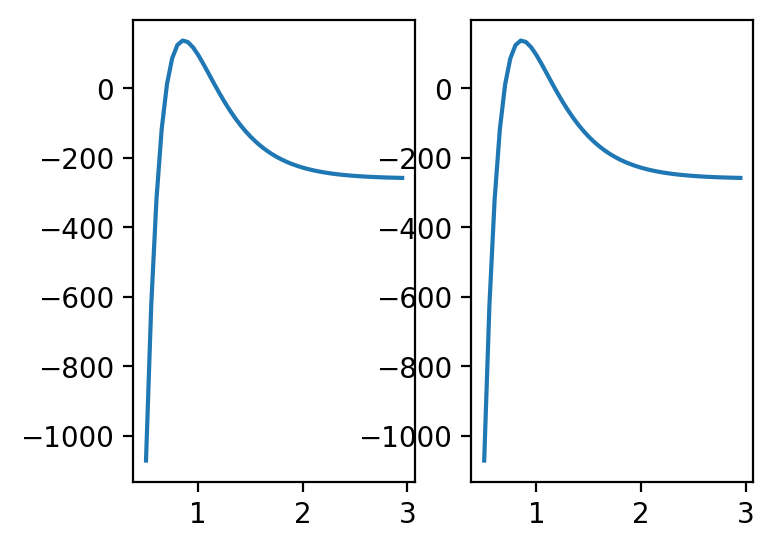

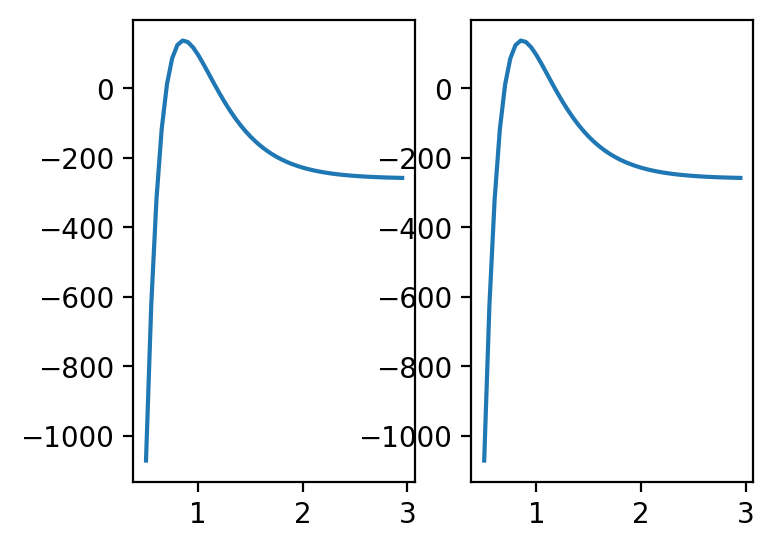

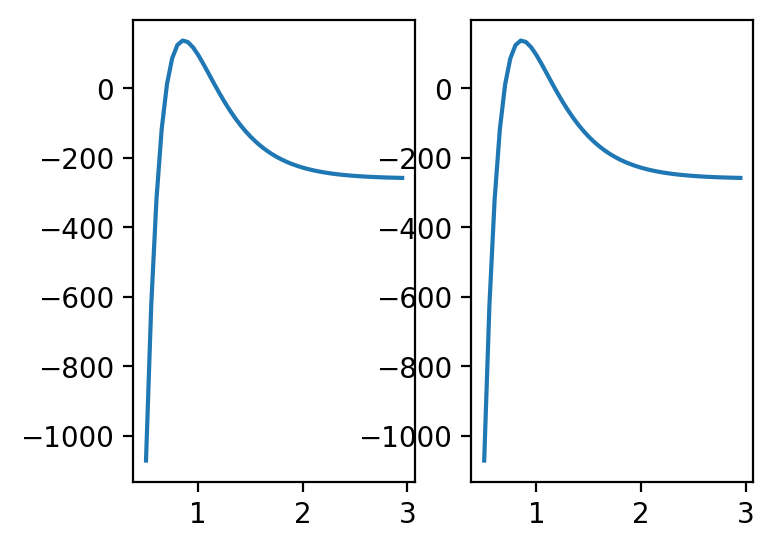

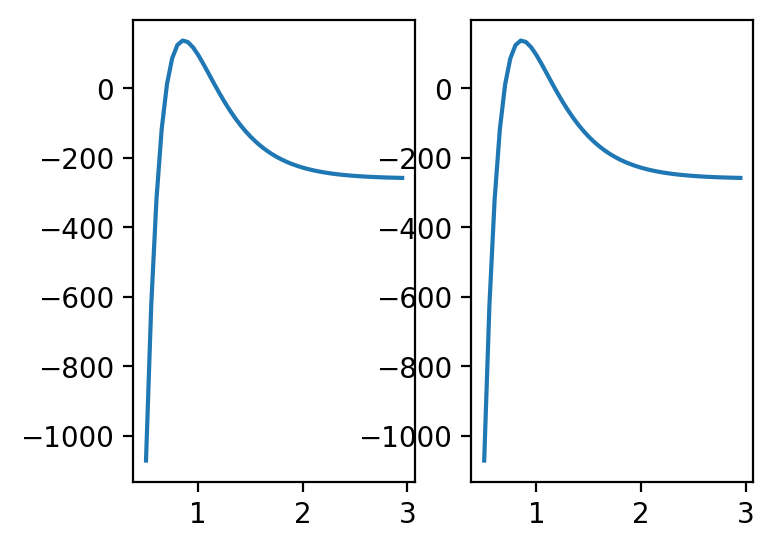

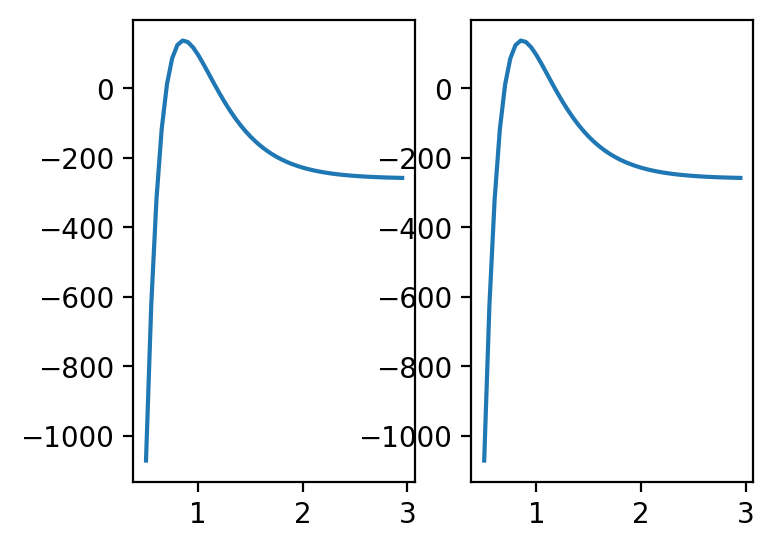

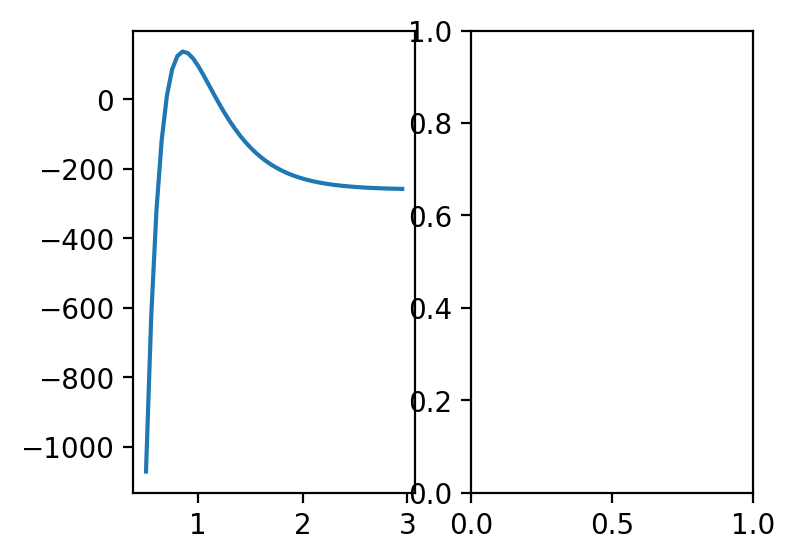

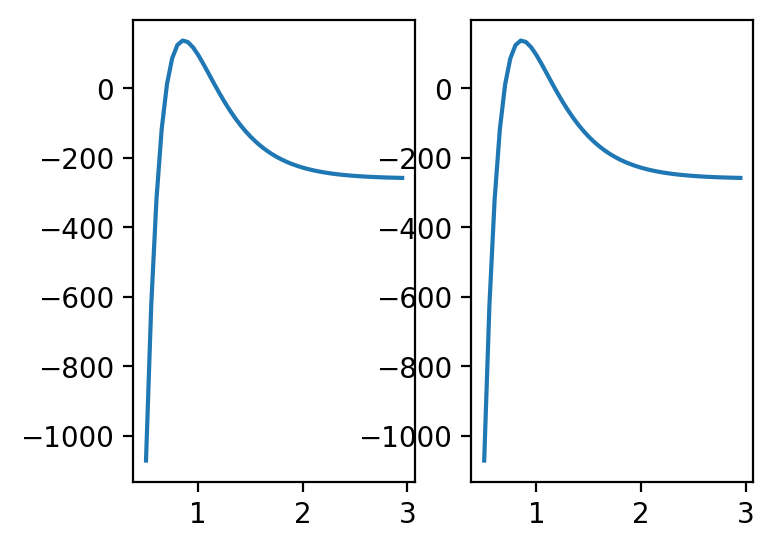

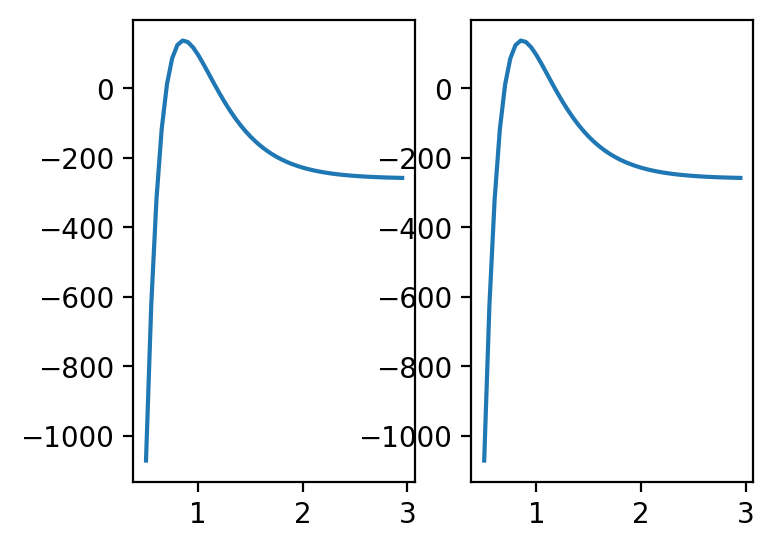

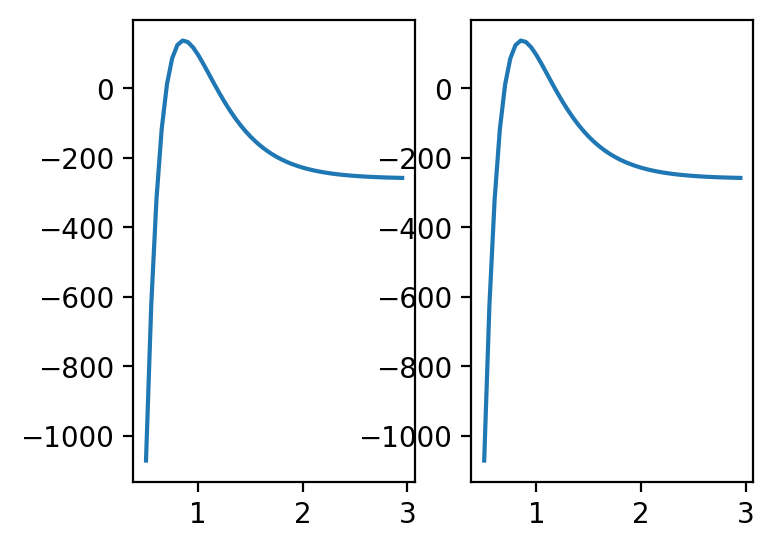

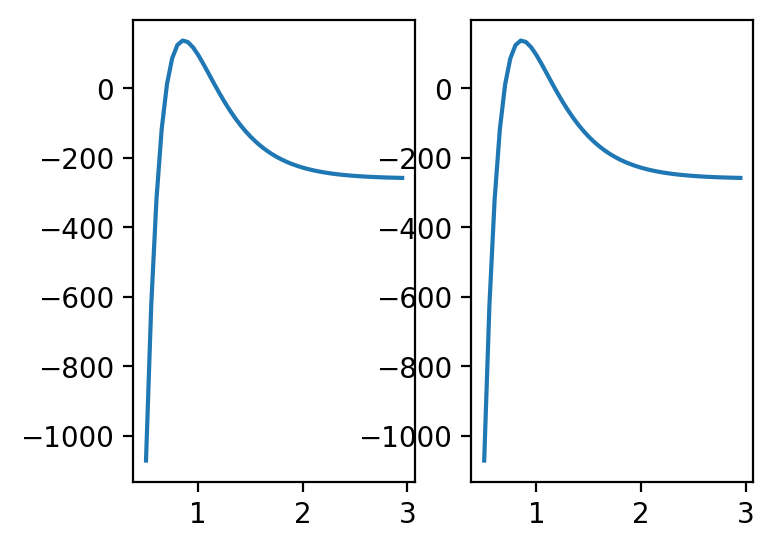

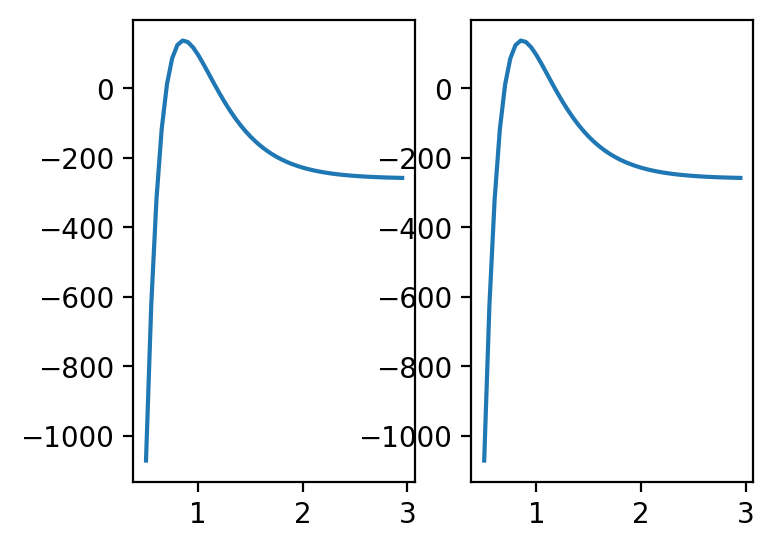

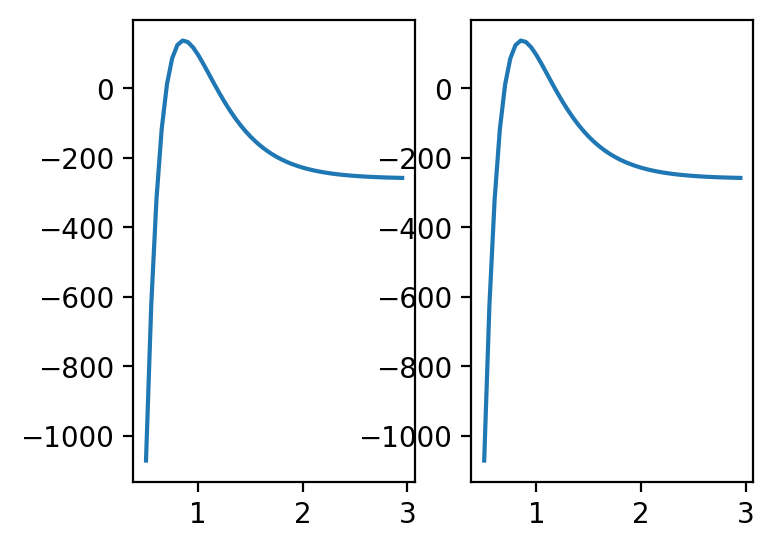

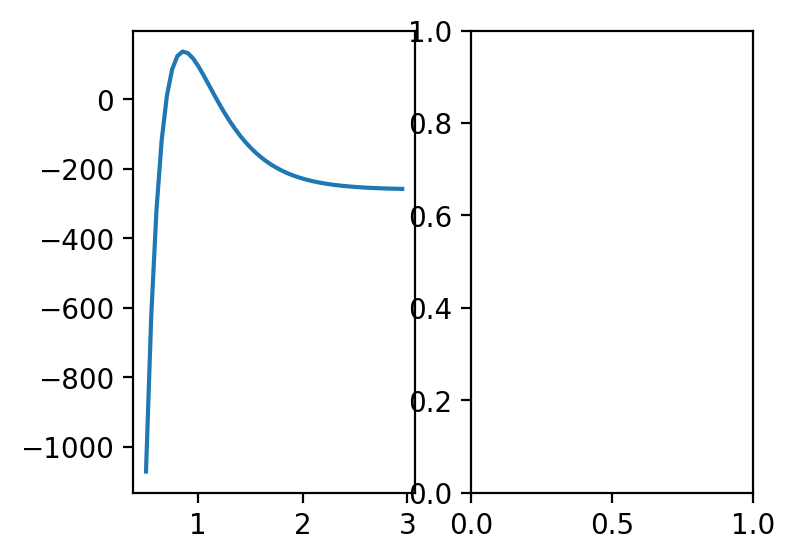

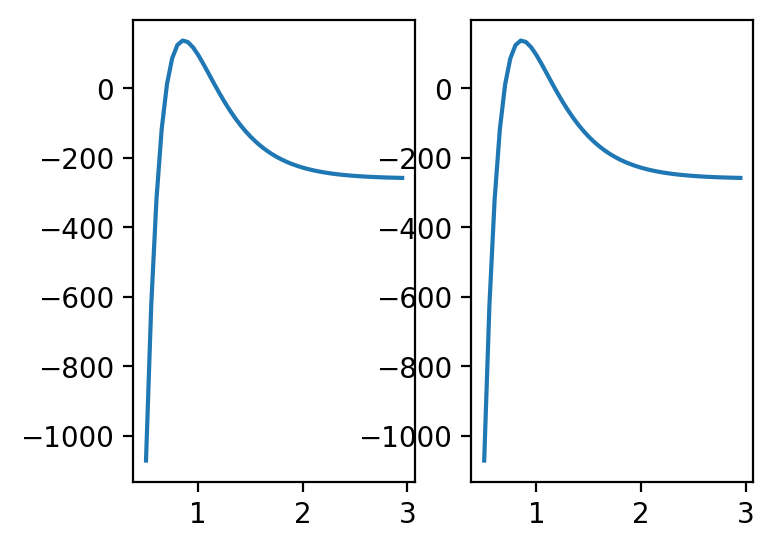

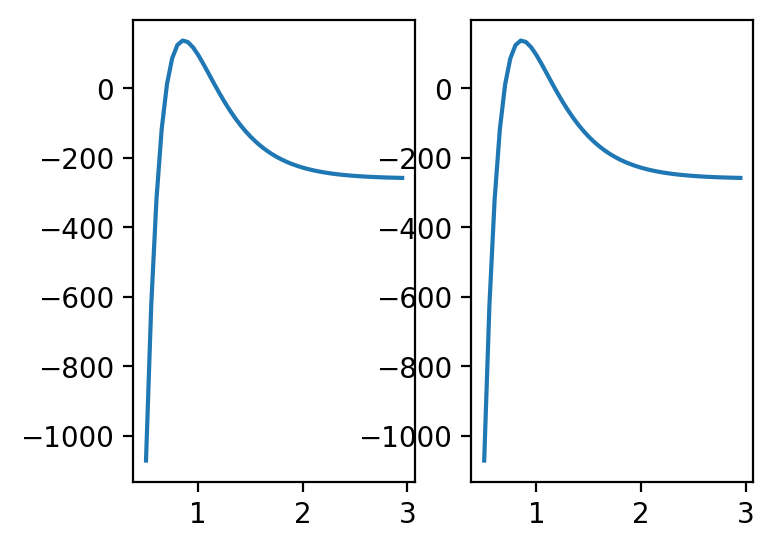

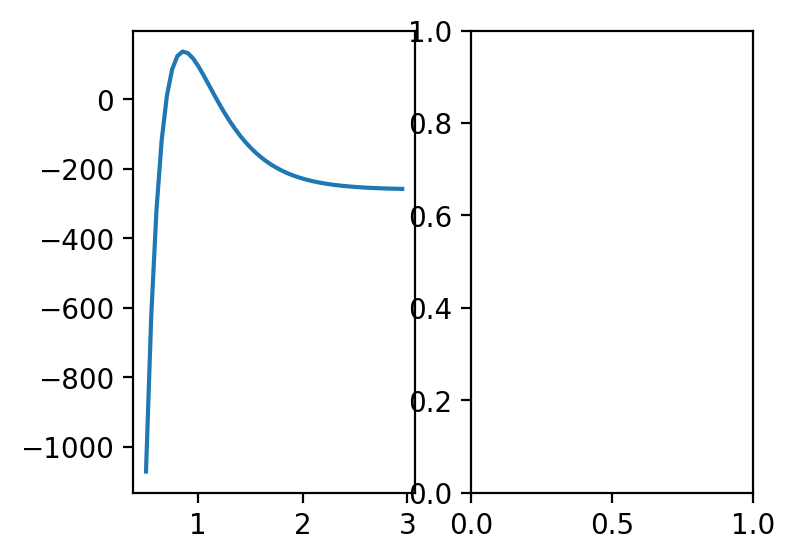

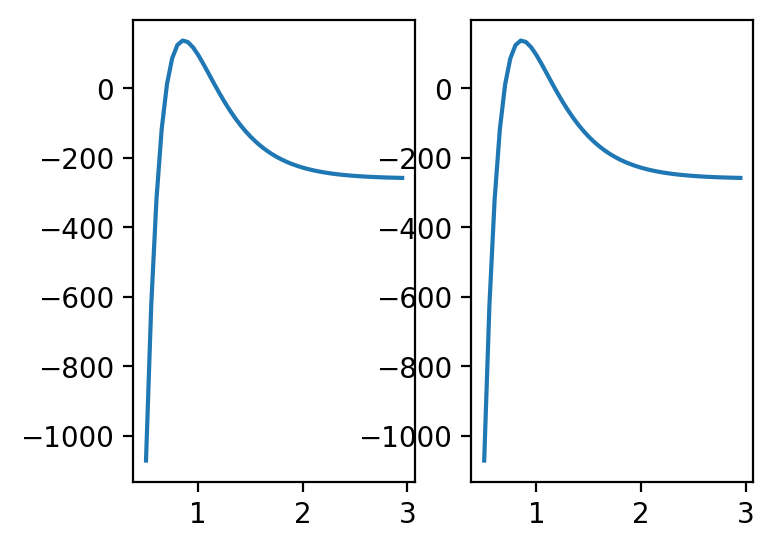

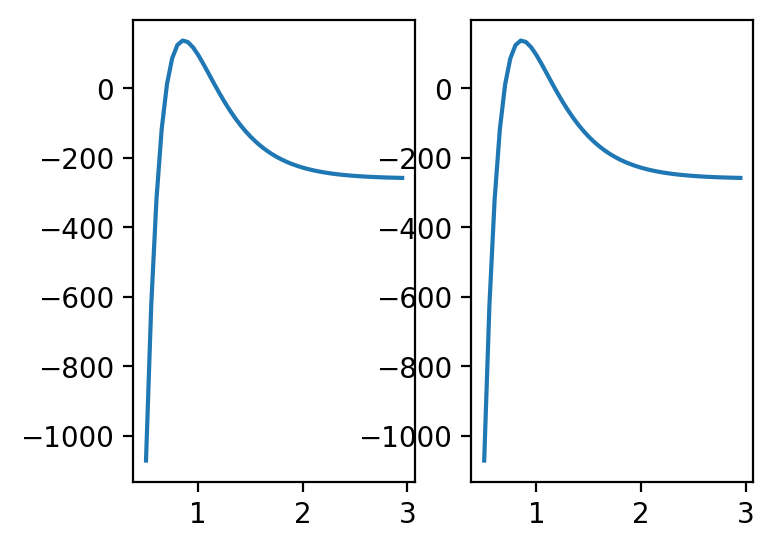

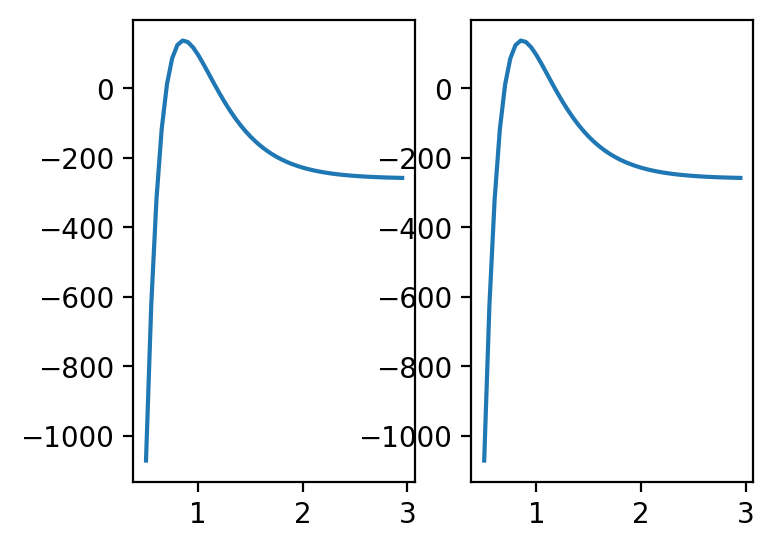

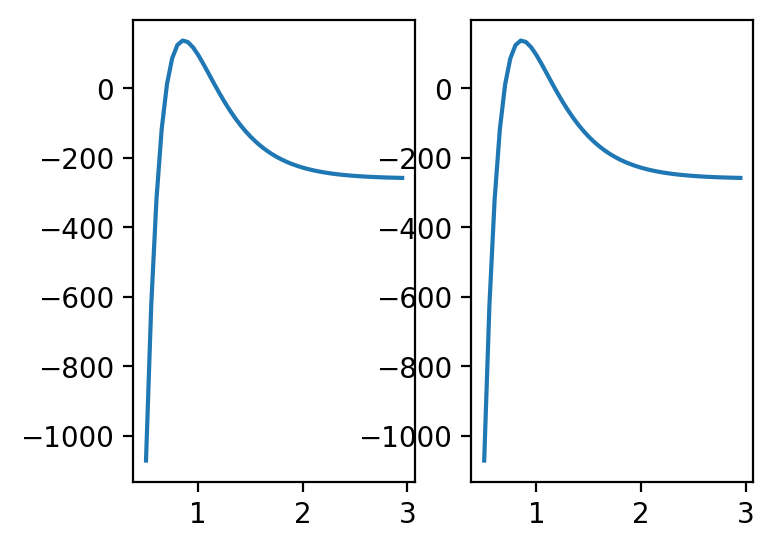

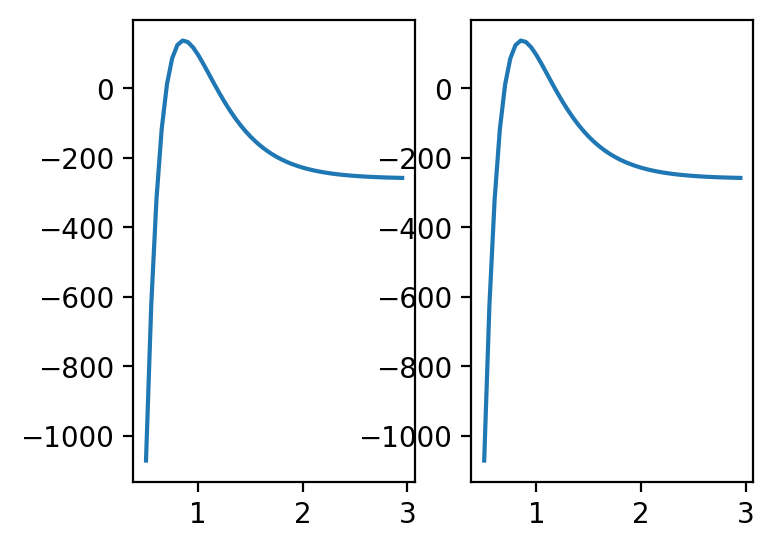

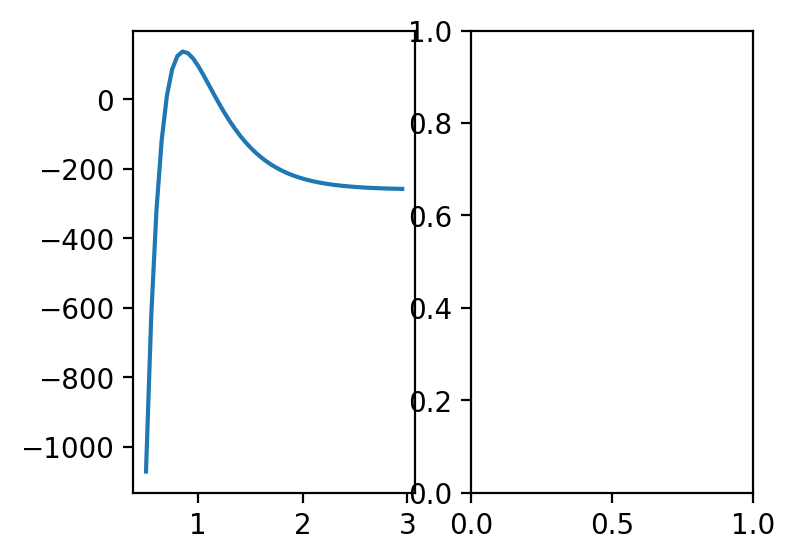

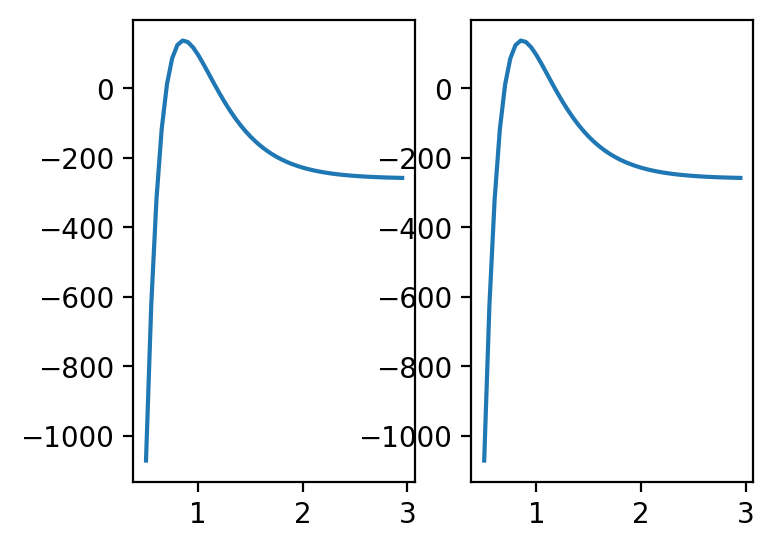

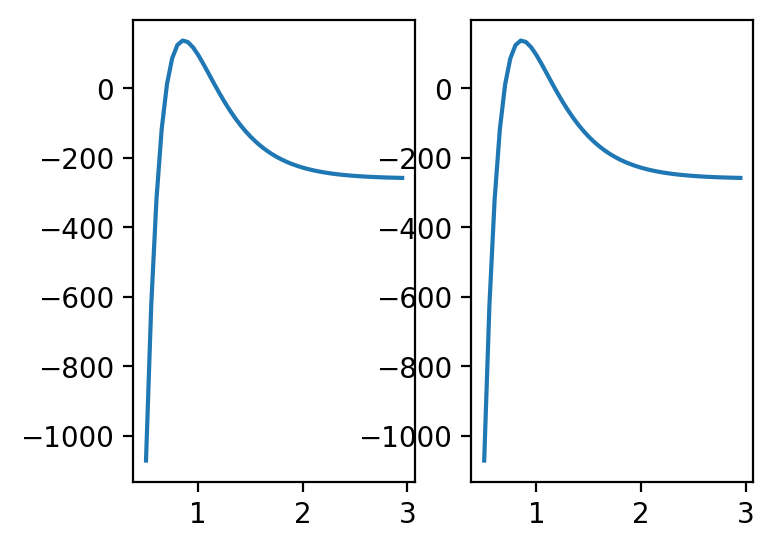

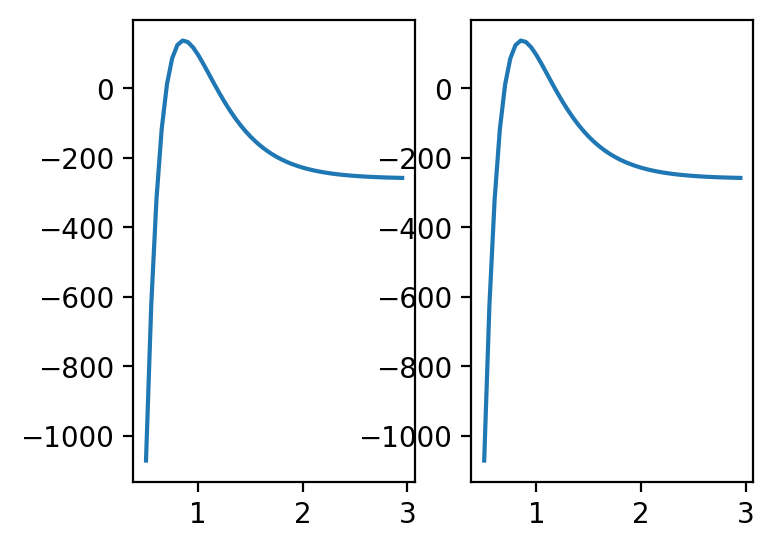

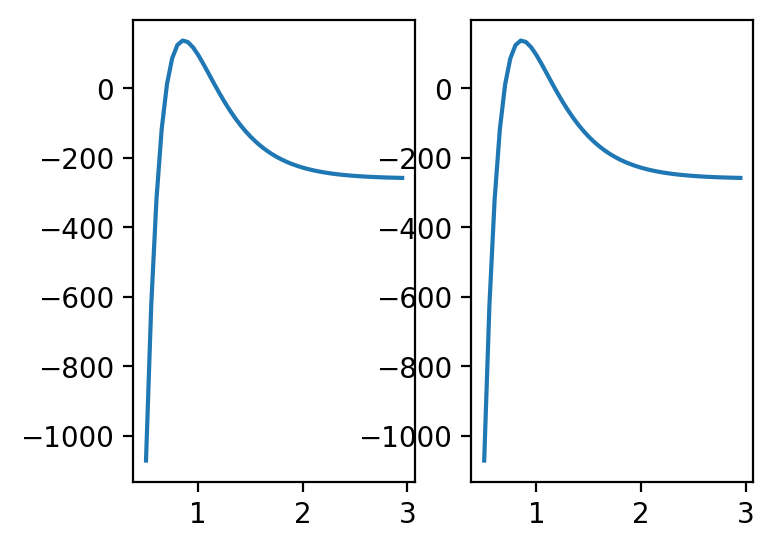

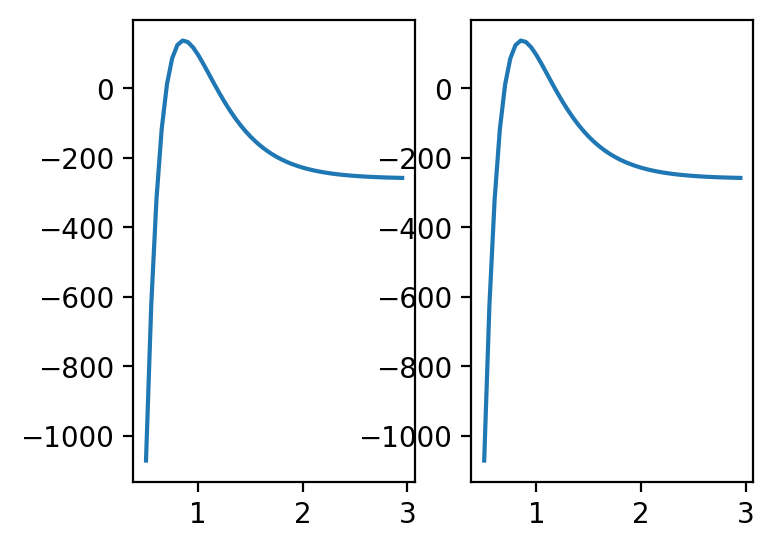

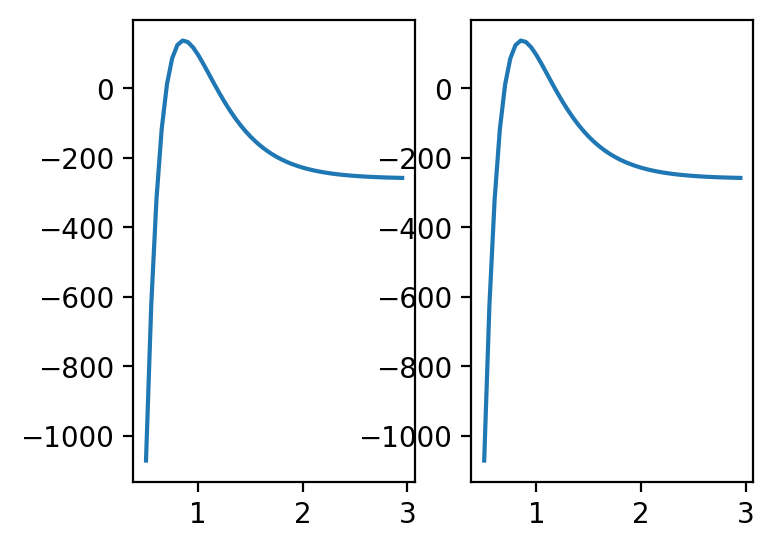

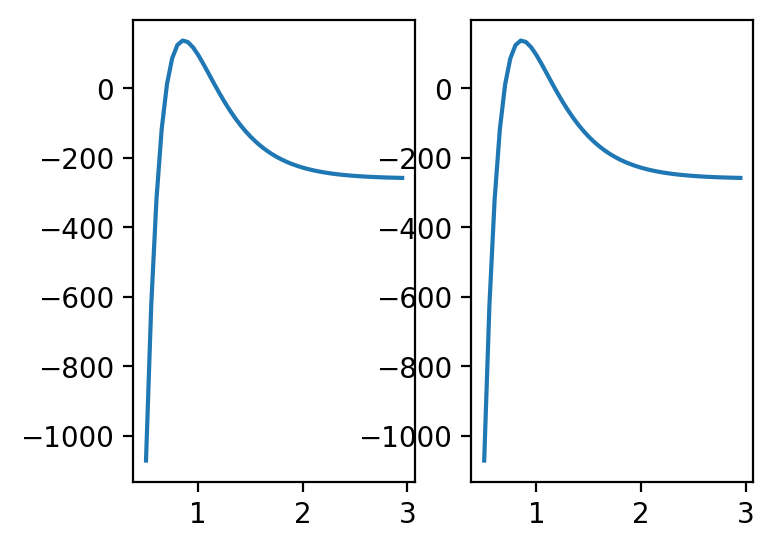

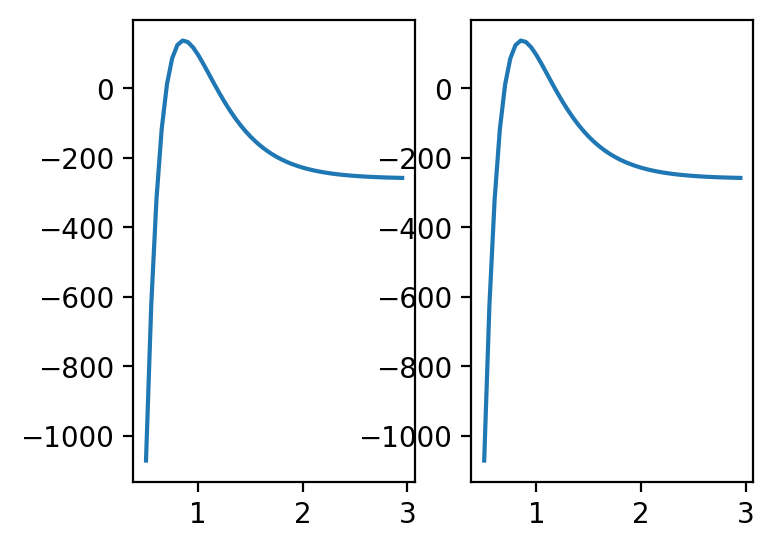

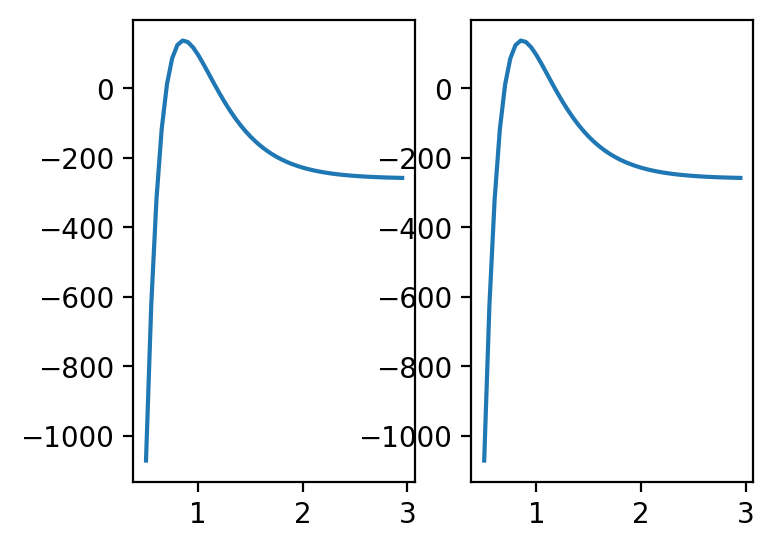

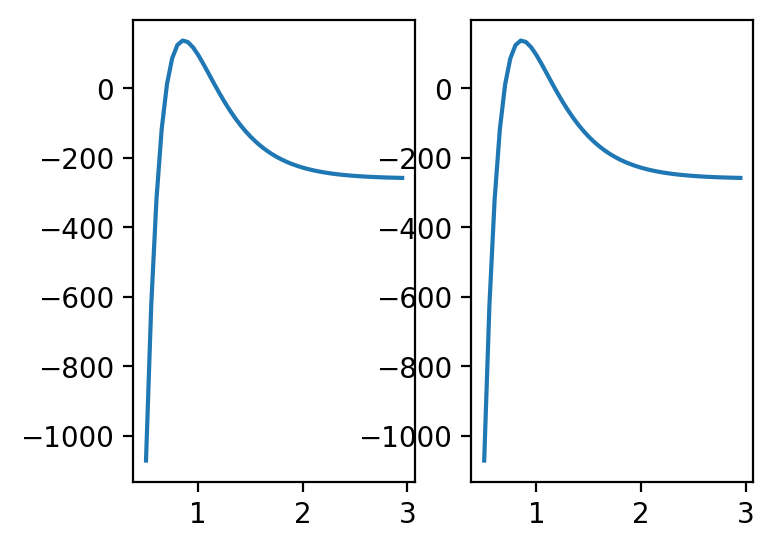

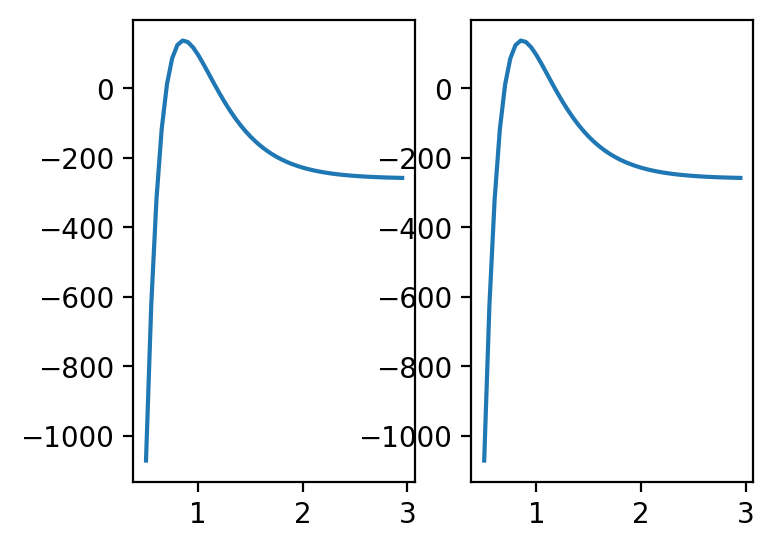

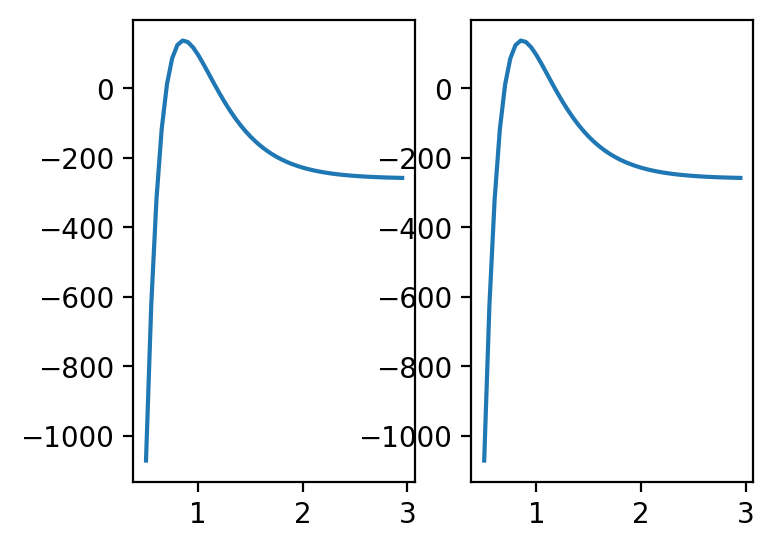

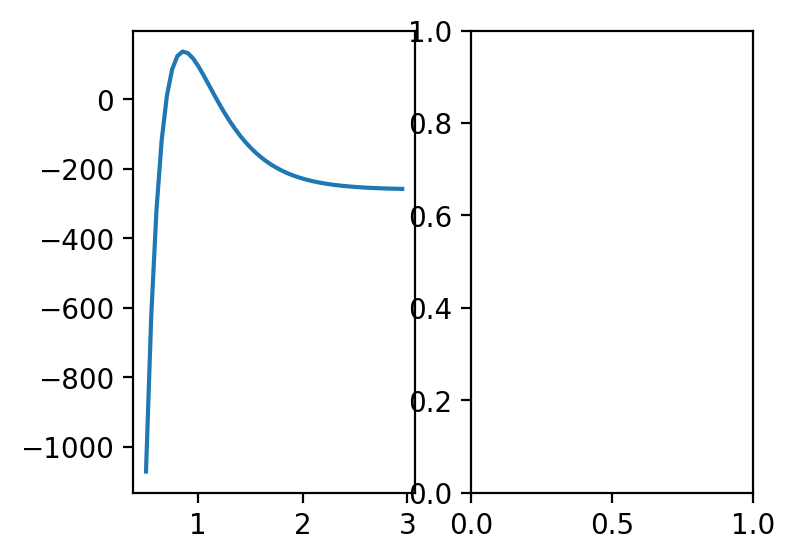

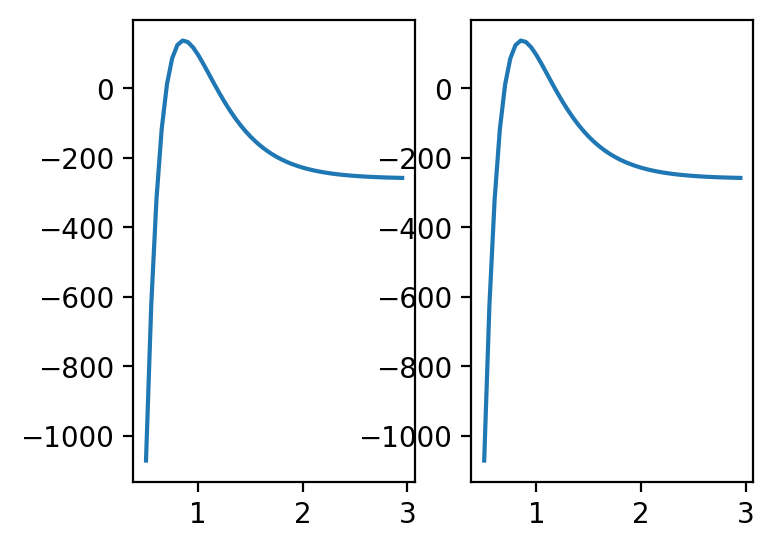

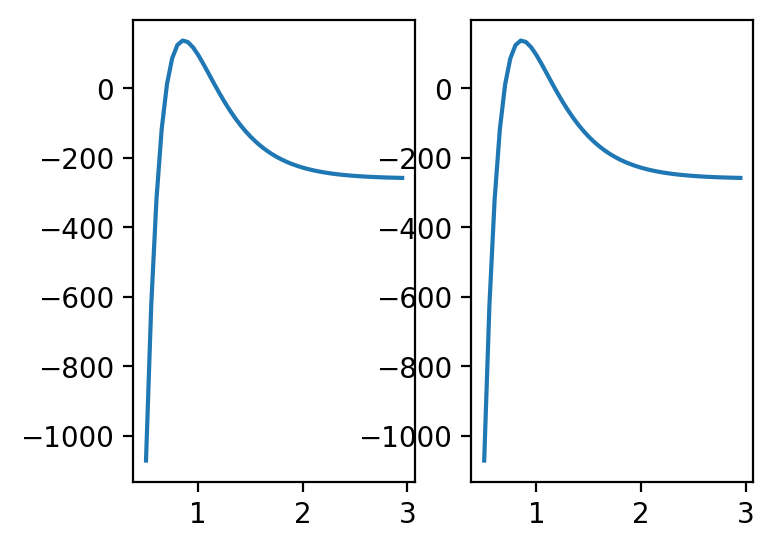

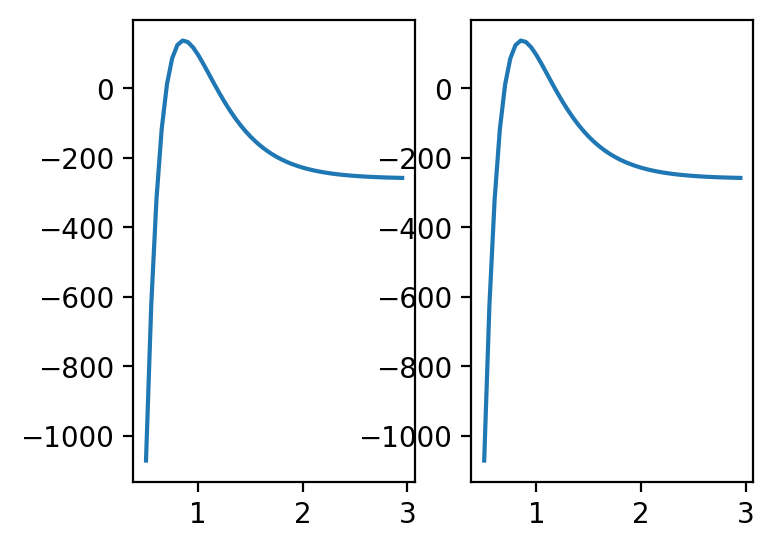

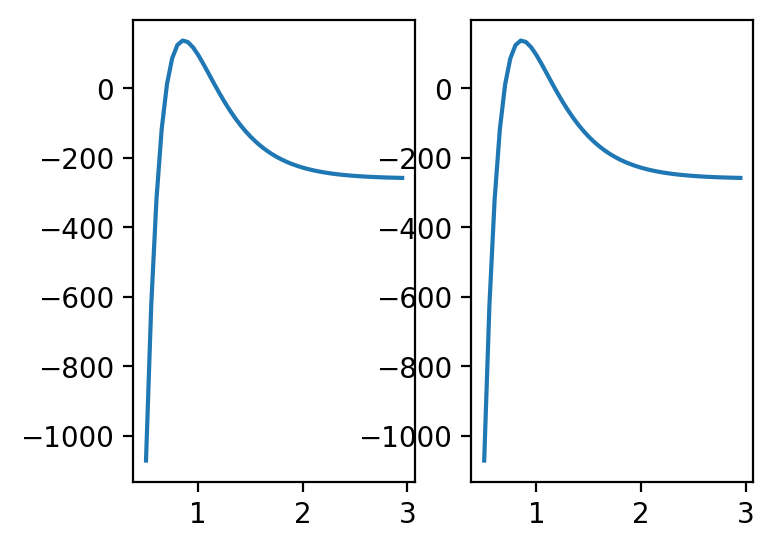

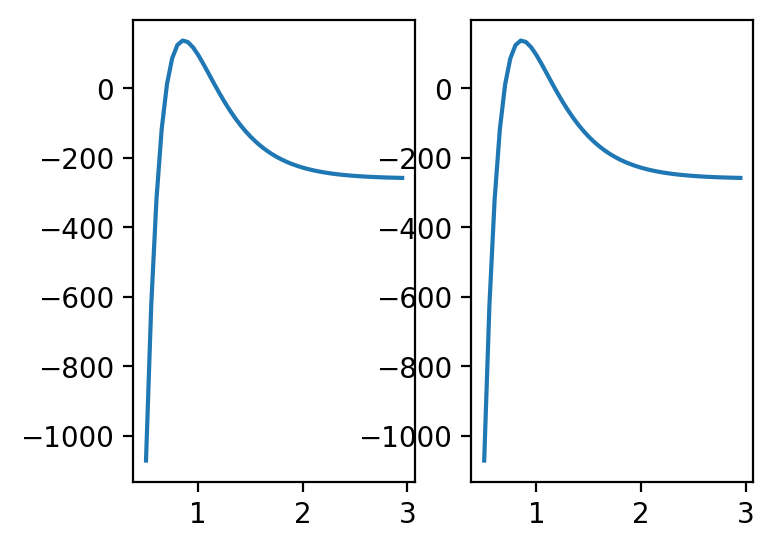

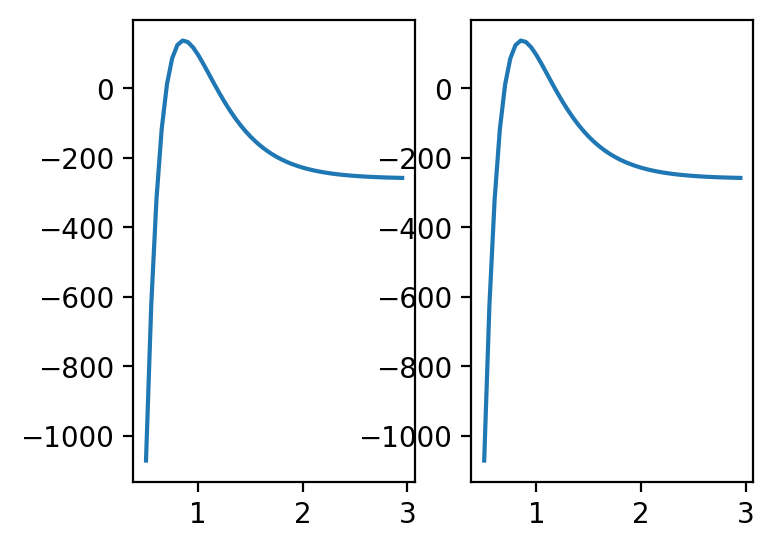

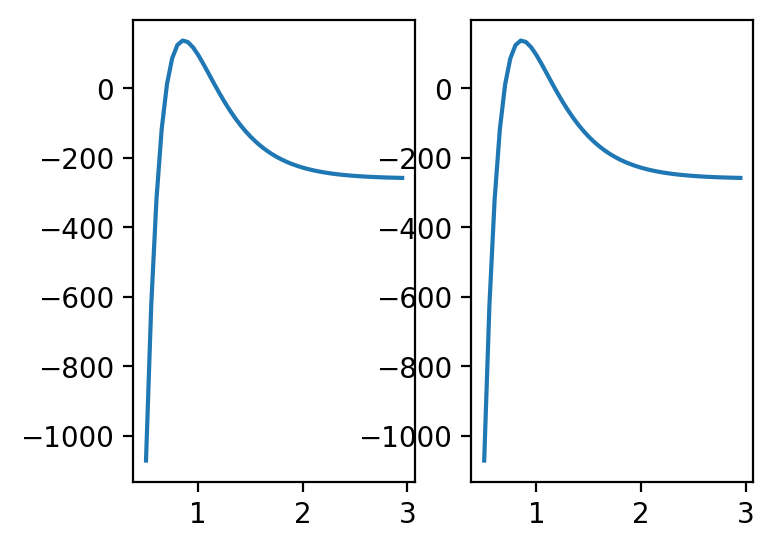

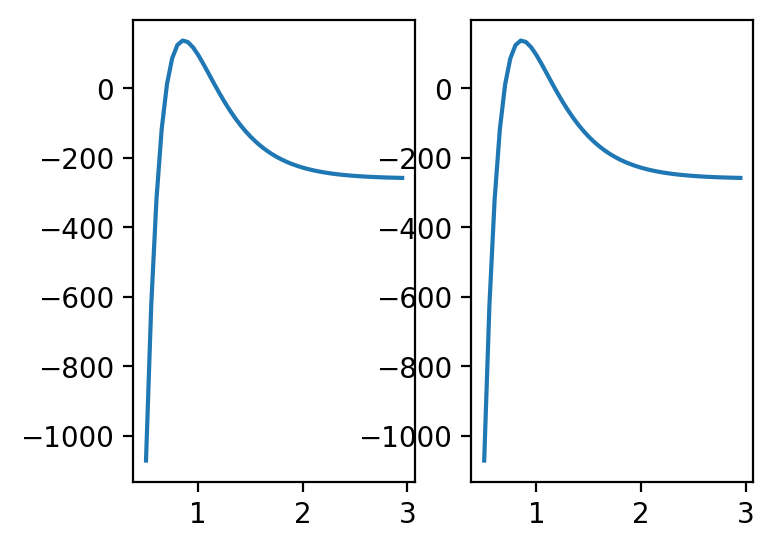

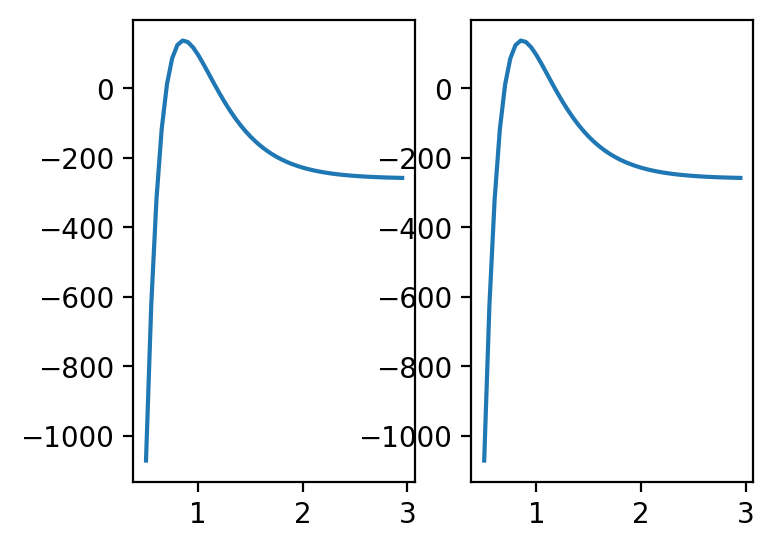

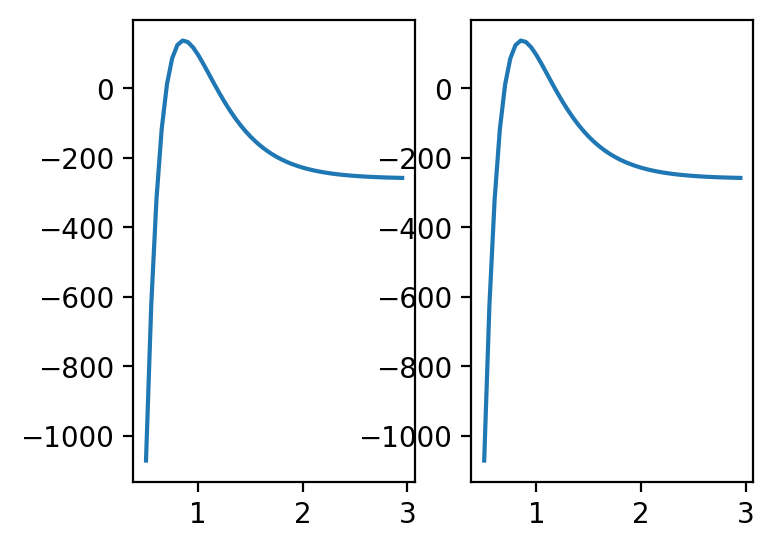

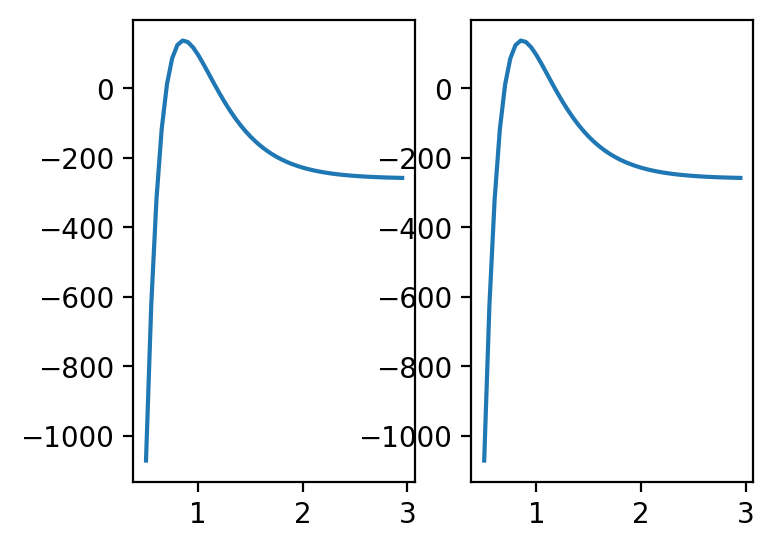

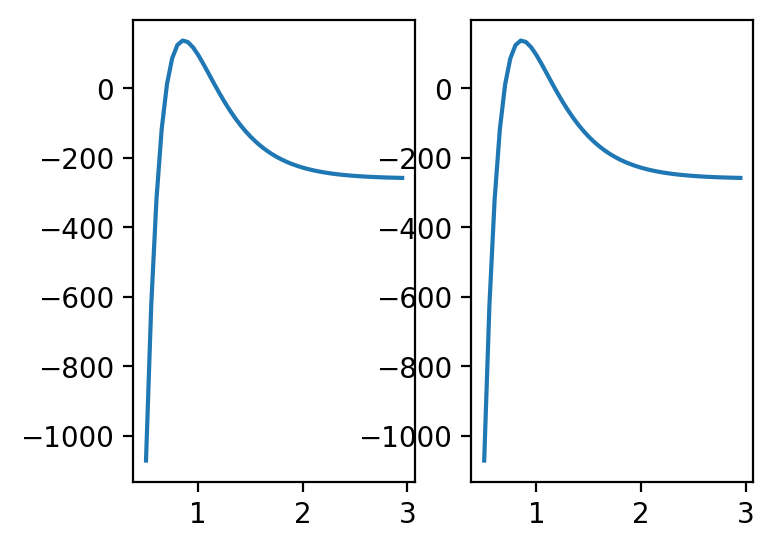

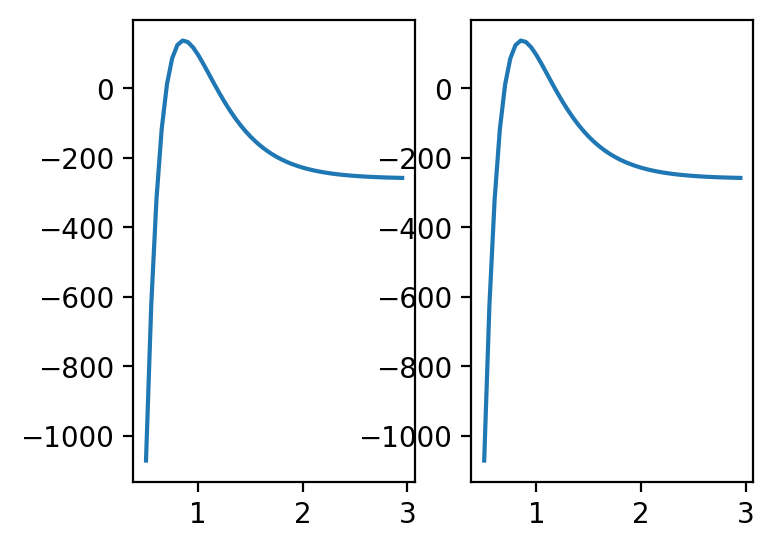

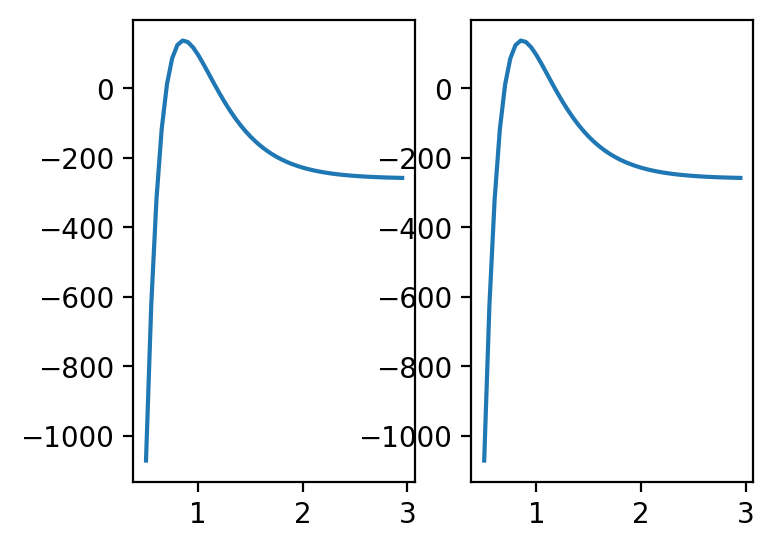

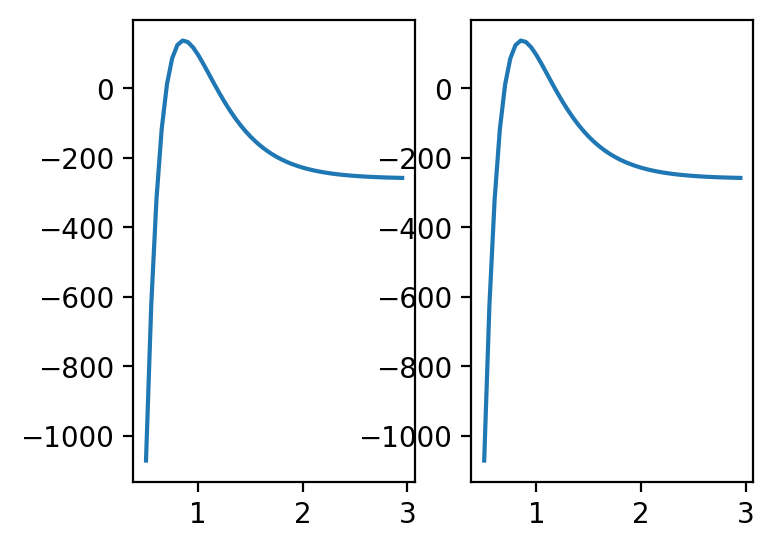

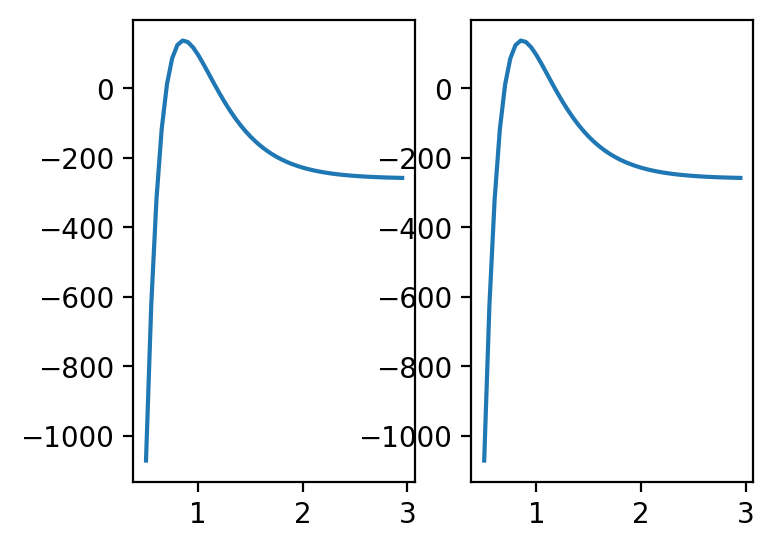

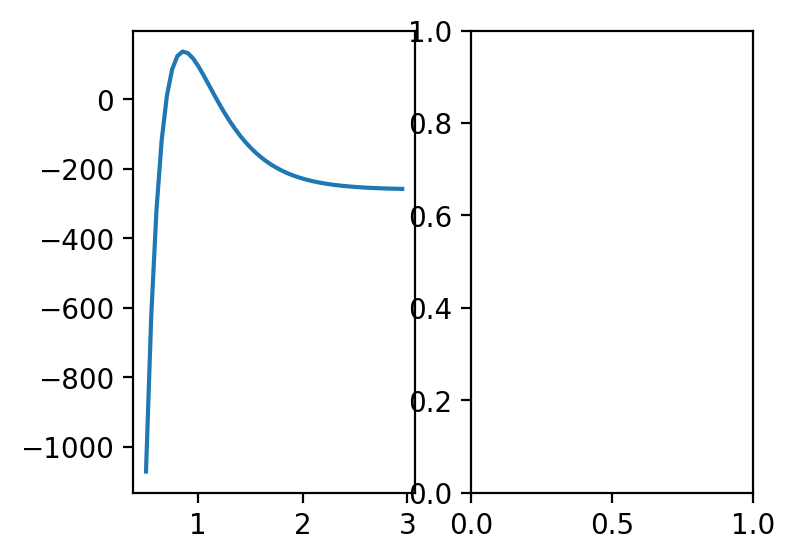

In [17]:
from botorch.optim import optimize_acqf

bounds = torch.tensor([[0.5], [3.0]], device=device, dtype=dtype)
num_trials = []

for trials in range(10):
    train_x = initial_x
    train_y = initial_y
    
    for step in range(60):
        # update and re-fit the GP .. we multiply by -1 because the default is to maximize
        std_y = standardize(-1*train_y)
        model = SimpleCustomGP(train_x, std_y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll);
        model.eval()
        
        f, ax = plt.subplots(1, 2, figsize=(4, 3))
        ax[0].plot(test_x.cpu().numpy(), -1*posterior.mean.cpu().numpy(), label="GP posterior")
        

        candidate, acqf_value = optimize_acqf(
            acq_function = UpperConfidenceBound(model=model, beta=1.0),
            #acq_function=ExpectedImprovement(model=model, best_f=torch.max(std_y)),
            #acq_function=ProbabilityOfImprovement(model=model, best_f=torch.max(std_y)),
            bounds=bounds,
            q=1, # no batches, just one at a time
            num_restarts=5,
            raw_samples=20
        )
        candidate_energy = morse(candidate)[0]
        step_norm = (train_x[-1] - candidate).norm()
        delta_energy = candidate_energy - train_y[-1]

        candidate_string = [f"{element:8.6f}" for element in candidate[0].tolist()]
        print(f"{step} {candidate_string} {candidate_energy[0].numpy():.4f} Delta={delta_energy[0].numpy():.4f} Norm={step_norm:.3f}")
        
        if candidate_energy < 0.5 and np.abs(delta_energy) < 0.01 and step_norm < 0.25:
            print(f"Done in {step}")
            num_trials.append(step)
            break
            
        train_x = torch.cat([train_x, candidate[0]])
        train_y = torch.cat([train_y, candidate_energy])
        ax[1].plot(test_x.cpu().numpy(), -1*posterior.mean.cpu().numpy(), label="GP posterior")

print("\nSummary:\n")
print(f"Did {len(num_trials)}, taking {np.mean(num_trials)} +/- {np.std(num_trials)}")